## Imports

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from collections import Counter
from tqdm import tqdm

import pickle
import warnings
import itertools

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)

## Uploading Data

In [4]:
df_app = pd.read_csv("application_data.csv")
df_desq = pd.read_csv("columns_description.csv")
df_desq = df_desq[["Table", "Row", "Description", "Special"]]
df_desq = df_desq[df_desq["Table"]=="application_data"]
print(f"Dimensions of the application datafarame: {df_app.shape}")
print(f"Dimensions of the columns description datafarame: {df_desq.shape}")

Dimensions of the application datafarame: (307511, 122)
Dimensions of the columns description datafarame: (122, 4)


## Quick View

In [5]:
# as dimension is quite high, I'll set pandas to show all rows/columns instead of couple of them
pd.set_option("display.max_rows", None, "display.max_columns", None)
# also let's set pandas to show full text in dataframe as previous application contains
# description of other variables
pd.set_option('display.max_colwidth', None)

In [6]:
df_app.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
df_desq

,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,application_data,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_data,CODE_GENDER,Gender of the client,NaN
4,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,application_data,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,application_data,CNT_CHILDREN,Number of children the client has,NaN
7,application_data,AMT_INCOME_TOTAL,Income of the client,NaN
8,application_data,AMT_CREDIT,Credit amount of the loan,NaN
9,application_data,AMT_ANNUITY,Loan annuity,NaN


In [8]:
df_app.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

## Data Cleaning

### 1) Check Missing Values

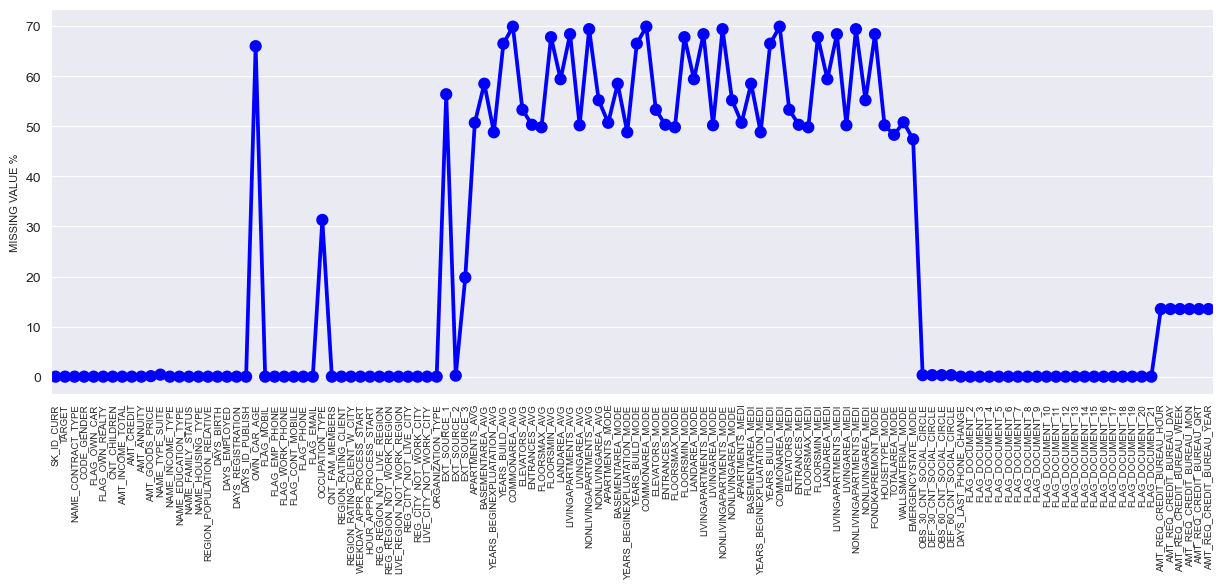

In [9]:
# application dataframe
plt.figure(figsize=(15,5))
sns.pointplot(x=list(df_app.columns),
              y=list(round(df_app.isnull().sum()/df_app.shape[0] * 100, 1)),
              color="b")
plt.ylabel("MISSING VALUE %", size=8)
plt.xticks(rotation='vertical', size=7)
plt.show()

### 2) Handling Missing Values

Firstly let's count how many variable we have with more than 40% missing values (probably we will have to remove them as filling ~50% missing values would be too much)

In [10]:
n1 = sum(round(df_app.isnull().sum()/df_app.shape[0] * 100, 1) > 40)
print(f"Number of columns with more than 40% missing values in df_app {n1}/{df_app.shape[1]}")

Number of columns with more than 40% missing values in df_app 49/122


In [11]:
# Check & record these columns 
df_cols_to_remove = []
for i, j in round(df_app.isnull().sum()/df_app.shape[0] * 100, 8).iteritems():
    if j>40:
        print(i, str(j)+"%")
        df_cols_to_remove.append(i)

OWN_CAR_AGE 65.99081008%
EXT_SOURCE_1 56.38107255%
APARTMENTS_AVG 50.74972928%
BASEMENTAREA_AVG 58.51595553%
YEARS_BEGINEXPLUATATION_AVG 48.78101922%
YEARS_BUILD_AVG 66.49778382%
COMMONAREA_AVG 69.87229725%
ELEVATORS_AVG 53.29597966%
ENTRANCES_AVG 50.34876801%
FLOORSMAX_AVG 49.76082156%
FLOORSMIN_AVG 67.84862981%
LANDAREA_AVG 59.37673774%
LIVINGAPARTMENTS_AVG 68.35495316%
LIVINGAREA_AVG 50.19332642%
NONLIVINGAPARTMENTS_AVG 69.43296337%
NONLIVINGAREA_AVG 55.17916432%
APARTMENTS_MODE 50.74972928%
BASEMENTAREA_MODE 58.51595553%
YEARS_BEGINEXPLUATATION_MODE 48.78101922%
YEARS_BUILD_MODE 66.49778382%
COMMONAREA_MODE 69.87229725%
ELEVATORS_MODE 53.29597966%
ENTRANCES_MODE 50.34876801%
FLOORSMAX_MODE 49.76082156%
FLOORSMIN_MODE 67.84862981%
LANDAREA_MODE 59.37673774%
LIVINGAPARTMENTS_MODE 68.35495316%
LIVINGAREA_MODE 50.19332642%
NONLIVINGAPARTMENTS_MODE 69.43296337%
NONLIVINGAREA_MODE 55.17916432%
APARTMENTS_MEDI 50.74972928%
BASEMENTAREA_MEDI 58.51595553%
YEARS_BEGINEXPLUATATION_MEDI 48.781

Generally, treshold for missing values is about 40% so let's remove columns with missing values more than that.

In [12]:
print(f"Shape of df_app before dropping: {df_app.shape}")
df_app = df_app[list(set(df_app.columns)-set(df_cols_to_remove))]
print(f"Shape of df_app after dropping: {df_app.shape}")
df_app = df_app[sorted(list(df_app.columns))]

Shape of df_app before dropping: (307511, 122)
Shape of df_app after dropping: (307511, 73)


Lets check other columns with missing values

In [13]:
left_cols_app = []
for i, j in round(df_app.isnull().sum()/df_app.shape[0] * 100, 2).iteritems():
    if j>0:
        print(i, str(j)+"%")
        left_cols_app.append(i)

AMT_GOODS_PRICE 0.09%
AMT_REQ_CREDIT_BUREAU_DAY 13.5%
AMT_REQ_CREDIT_BUREAU_HOUR 13.5%
AMT_REQ_CREDIT_BUREAU_MON 13.5%
AMT_REQ_CREDIT_BUREAU_QRT 13.5%
AMT_REQ_CREDIT_BUREAU_WEEK 13.5%
AMT_REQ_CREDIT_BUREAU_YEAR 13.5%
DEF_30_CNT_SOCIAL_CIRCLE 0.33%
DEF_60_CNT_SOCIAL_CIRCLE 0.33%
EXT_SOURCE_2 0.21%
EXT_SOURCE_3 19.83%
NAME_TYPE_SUITE 0.42%
OBS_30_CNT_SOCIAL_CIRCLE 0.33%
OBS_60_CNT_SOCIAL_CIRCLE 0.33%
OCCUPATION_TYPE 31.35%


In [14]:
non_missing_cols = []
for i, j in round(df_app.isnull().sum()/df_app.shape[0] * 100, 1).iteritems():
    if j==0:
        non_missing_cols.append(i)

In [15]:
df_app[left_cols_app].describe()

,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
count,3.072330e+05,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,306490.000000,306490.000000,3.068510e+05,246546.000000,306490.000000,306490.000000
mean,5.383962e+05,0.007000,0.006402,0.267395,0.265474,0.034362,1.899974,0.143421,0.100049,5.143927e-01,0.510853,1.422245,1.405292
std,3.694465e+05,0.110757,0.083849,0.916002,0.794056,0.204685,1.869295,0.446698,0.362291,1.910602e-01,0.194844,2.400989,2.379803
min,4.050000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000
25%,2.385000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.924574e-01,0.370650,0.000000,0.000000
50%,4.500000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.659614e-01,0.535276,0.000000,0.000000
75%,6.795000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,6.636171e-01,0.669057,2.000000,2.000000
max,4.050000e+06,9.000000,4.000000,27.000000,261.000000,8.000000,25.000000,34.000000,24.000000,8.549997e-01,0.896010,348.000000,344.000000


#####  2.1) Separate Categorical/Numerical Columns (columns with missing values)

In [16]:
df_desq[df_desq["Row"].isin(left_cols_app)]

,Table,Row,Description,Special
10,application_data,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,NaN
11,application_data,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,NaN
28,application_data,OCCUPATION_TYPE,What kind of occupation does the client have,NaN
42,application_data,EXT_SOURCE_2,Normalized score from external data source,normalized
43,application_data,EXT_SOURCE_3,Normalized score from external data source,normalized
91,application_data,OBS_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 30 DPD (days past due) default,NaN
92,application_data,DEF_30_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 30 DPD (days past due),NaN
93,application_data,OBS_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings with observable 60 DPD (days past due) default,NaN
94,application_data,DEF_60_CNT_SOCIAL_CIRCLE,How many observation of client's social surroundings defaulted on 60 (days past due) DPD,NaN
116,application_data,AMT_REQ_CREDIT_BUREAU_HOUR,Number of enquiries to Credit Bureau about the client one hour before application,NaN


In [17]:
numerical_features = ["AMT_GOODS_PRICE", "EXT_SOURCE_2", "EXT_SOURCE_3",
                      "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                      "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE",
                      "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY",
                      "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                      "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
categorica_features = ["NAME_TYPE_SUITE", "OCCUPATION_TYPE"]

* Firstly I'll fill missing values in categorical features;
* For numerical features I want to use KNNImputer.

##### 2.2) **NAME_TYPE_SUITE**

In [18]:
print("Number of missing values in NAME_TYPE_SUITE: {}".format(df_app[["NAME_TYPE_SUITE"]].isnull().sum()[0]))

Number of missing values in NAME_TYPE_SUITE: 1292


In [19]:
round(df_app["NAME_TYPE_SUITE"].value_counts()/sum(df_app["NAME_TYPE_SUITE"].value_counts()) * 100, 1)

Unaccompanied      81.2
Family             13.1
Spouse, partner     3.7
Children            1.1
Other_B             0.6
Other_A             0.3
Group of people     0.1
Name: NAME_TYPE_SUITE, dtype: float64

**Solution:** 
* As 81.2% of the observation belongs to "Unacompanied" class, it should be fine if we replce missing values with it.

##### 2.3) **OCCUPATION_TYPE**

In [20]:
print("Number of missing values in OCCUPATION_TYPE: {}".format(df_app[["OCCUPATION_TYPE"]].isnull().sum()[0]))

Number of missing values in OCCUPATION_TYPE: 96391


In [21]:
round(df_app["OCCUPATION_TYPE"].value_counts()/sum(df_app["OCCUPATION_TYPE"].value_counts()) * 100, 1)

Laborers                 26.1
Sales staff              15.2
Core staff               13.1
Managers                 10.1
Drivers                   8.8
High skill tech staff     5.4
Accountants               4.6
Medicine staff            4.0
Security staff            3.2
Cooking staff             2.8
Cleaning staff            2.2
Private service staff     1.3
Low-skill Laborers        1.0
Waiters/barmen staff      0.6
Secretaries               0.6
Realty agents             0.4
HR staff                  0.3
IT staff                  0.2
Name: OCCUPATION_TYPE, dtype: float64

In [22]:
dic = {"Laborers": 26.1, "Sales staff": 15.2, "Core staff": 13.1,
       "Managers": 10.1, "Drivers": 8.8}
weights = [dic[weight] / sum(dic.values()) for weight in dic.keys()]
print(weights)

[0.35607094133697137, 0.2073669849931787, 0.17871759890859482, 0.1377899045020464, 0.12005457025920875]


**Solution:** 
* There are 5 dominant classes, so filling missing values with randomly chosen class from these categories (with corresponding weights) should work fine.

##### 2.4) Filling missing values in **NAME_TYPE_SUITE** / **OCCUPATION_TYPE**

In [23]:
df_app["NAME_TYPE_SUITE"].fillna("Unaccompanied", inplace=True)

In [24]:
random.seed(4444)
values = random.choices(list(dic.keys()), weights=weights, k=96391)
df_app.loc[df_app["OCCUPATION_TYPE"].isna(), "OCCUPATION_TYPE"] = values

In [25]:
numerical_features

['AMT_GOODS_PRICE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

##### 2.5) **CHECK MISSING VALUE GRAPH**

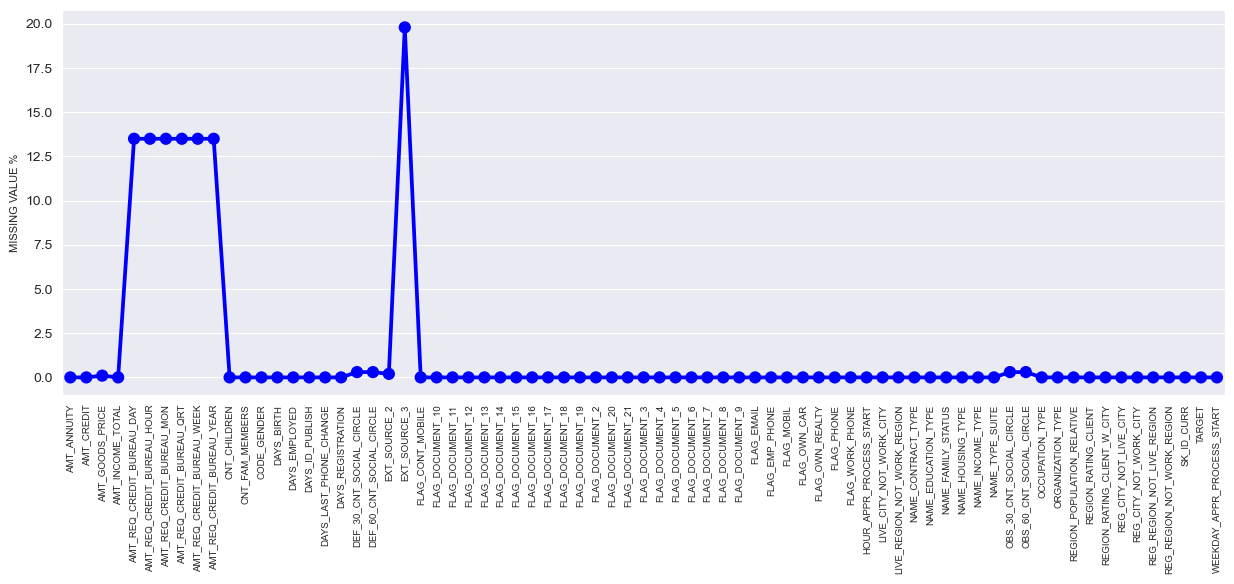

In [26]:
plt.figure(figsize=(15,5))
sns.pointplot(x=list(df_app.columns),
              y=list(round(df_app.isnull().sum()/df_app.shape[0] * 100, 1)),
              color="b")
plt.ylabel("MISSING VALUE %", size=8)
plt.xticks(rotation='vertical', size=7)
plt.show()

Seems AMT variables have most of the missing values.

##### 2.6) **AMT_GOODS_PRICE**

In [27]:
print("Number of missing values in AMT_GOODS_PRICE: {}".format(df_app[["AMT_GOODS_PRICE"]].isnull().sum()[0]))

Number of missing values in AMT_GOODS_PRICE: 278


In [28]:
df_app["AMT_GOODS_PRICE"].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

**Solution:** 
* There are few missing values in this column (not even 1% of observations), so filling it with simple median (4.500000e+05) should work fine.

##### 2.7) **EXT_SOURCE_2**

In [29]:
print("Number of missing values in EXT_SOURCE_2: {}".format(df_app[["EXT_SOURCE_2"]].isnull().sum()[0]))

Number of missing values in EXT_SOURCE_2: 660


In [30]:
df_app["EXT_SOURCE_2"].describe()

count    3.068510e+05
mean     5.143927e-01
std      1.910602e-01
min      8.173617e-08
25%      3.924574e-01
50%      5.659614e-01
75%      6.636171e-01
max      8.549997e-01
Name: EXT_SOURCE_2, dtype: float64

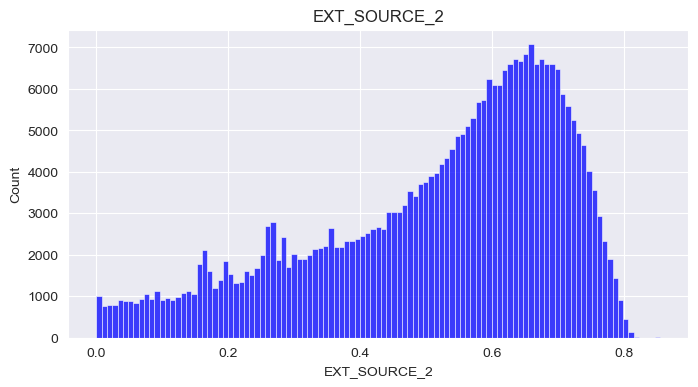

In [31]:
plt.figure(figsize=(8,4))
sns.histplot(df_app["EXT_SOURCE_2"],color="b")
plt.title("EXT_SOURCE_2")
plt.show()

**Solution:** 
* Here number of outliers is about 1.5%, so missing values with median should work fine (5.659614e-01).

In [32]:
df_app[["TARGET"]].head()

,TARGET
0,1
1,0
2,0
3,0
4,0


##### 2.7) **EXT_SOURCE_3**

In [33]:
print("Number of missing values in EXT_SOURCE_3: {}".format(df_app[["EXT_SOURCE_3"]].isnull().sum()[0]))

Number of missing values in EXT_SOURCE_3: 60965


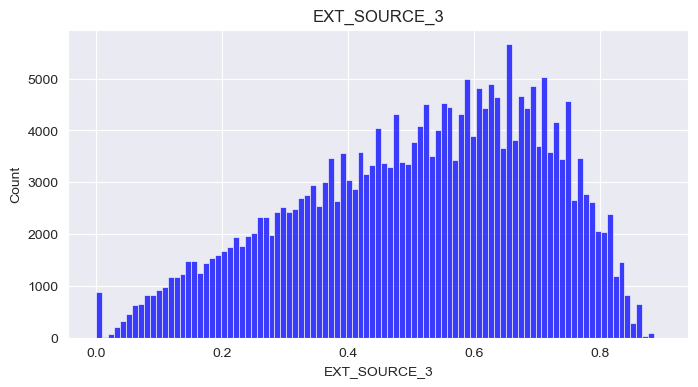

In [34]:
plt.figure(figsize=(8,4))
sns.histplot(df_app["EXT_SOURCE_3"],color="b")
plt.title("EXT_SOURCE_3")
plt.show()

**Solution:** 
* 19.8% of observations are missing in EXT_SOURCE_3. 20% is quite high, so filling observations with simple median or mean should not be appropriate idea. I think leaving this columns as it is and let algorithms to take care of missing values (I want to use XGBoost in this case which supports missing values by default).

##### 2.8) **OBS_30_CNT_SOCIAL_CIRCLE**

In [35]:
print("Number of missing values in OBS_30_CNT_SOCIAL_CIRCLE: {}".format(df_app[["OBS_30_CNT_SOCIAL_CIRCLE"]].isnull().sum()[0]))

Number of missing values in OBS_30_CNT_SOCIAL_CIRCLE: 1021


In [36]:
df_app["OBS_30_CNT_SOCIAL_CIRCLE"].value_counts()

0.0      163910
1.0       48783
2.0       29808
3.0       20322
4.0       14143
5.0        9553
6.0        6453
7.0        4390
8.0        2967
9.0        2003
10.0       1376
11.0        852
12.0        652
13.0        411
14.0        258
15.0        166
16.0        133
17.0         88
18.0         46
19.0         44
20.0         30
21.0         29
22.0         22
23.0         15
25.0         11
24.0         11
27.0          5
26.0          3
30.0          2
28.0          1
29.0          1
47.0          1
348.0         1
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: int64

In [37]:
dic_1 = {0: 163910, 1: 48783, 2: 29808,
       3: 20322, 4: 14143}
weights_1 = [dic_1[weights] / sum(dic_1.values()) for weights in dic_1.keys()]
print(weights_1)

[0.5918054923709047, 0.17613353263577478, 0.10762331838565023, 0.07337362708780139, 0.05106402951986887]


**Soution**
* This values in this column is discrete, so I'll use the five most common value and choose randomly from them with corresponding weights.

##### 2.9) **DEF_30_CNT_SOCIAL_CIRCLE**

In [38]:
print("Number of missing values in DEF_30_CNT_SOCIAL_CIRCLE: {}".format(df_app[["DEF_30_CNT_SOCIAL_CIRCLE"]].isnull().sum()[0]))

Number of missing values in DEF_30_CNT_SOCIAL_CIRCLE: 1021


In [39]:
df_app["DEF_30_CNT_SOCIAL_CIRCLE"].value_counts()

0.0     271324
1.0      28328
2.0       5323
3.0       1192
4.0        253
5.0         56
6.0         11
7.0          1
34.0         1
8.0          1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64

**Solution**
* Here dominant value is 0.0, so filling these ~1000 observations with it should not be a ploblem.

##### 2.10) **OBS_60_CNT_SOCIAL_CIRCLE**

In [40]:
print("Number of missing values in OBS_60_CNT_SOCIAL_CIRCLE: {}".format(df_app[["OBS_60_CNT_SOCIAL_CIRCLE"]].isnull().sum()[0]))

Number of missing values in OBS_60_CNT_SOCIAL_CIRCLE: 1021


In [41]:
df_app["OBS_60_CNT_SOCIAL_CIRCLE"].value_counts()

0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
27.0          5
29.0          2
28.0          1
47.0          1
344.0         1
30.0          1
26.0          1
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: int64

In [42]:
dic_2 = {0: 164666, 1: 48870, 2: 29766,
         3: 20215, 4: 13946}
weights_2 = [dic_2[weights] / sum(dic_2.values()) for weights in dic_2.keys()]
print(weights_2)

[0.5934701203403697, 0.1761315923204175, 0.10727916875403207, 0.07285656105498751, 0.050262557530193215]


**Soution**
* Here randomly chosen values from the five most common values with weighted probabilities should work fine.

##### 2.11) **DEF_60_CNT_SOCIAL_CIRCLE**

In [43]:
print("Number of missing values in DEF_60_CNT_SOCIAL_CIRCLE: {}".format(df_app[["DEF_60_CNT_SOCIAL_CIRCLE"]].isnull().sum()[0]))

Number of missing values in DEF_60_CNT_SOCIAL_CIRCLE: 1021


In [44]:
df_app["DEF_60_CNT_SOCIAL_CIRCLE"].value_counts()

0.0     280721
1.0      21841
2.0       3170
3.0        598
4.0        135
5.0         20
6.0          3
7.0          1
24.0         1
Name: DEF_60_CNT_SOCIAL_CIRCLE, dtype: int64

**Solution**
* Here dominant value is 0.0, so filling these ~1000 observations with it should not be a ploblem.

##### 2.12 **AMT** VARIABLES CORRELATION TO TARGET

In [45]:
df_app[["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
        "TARGET"]].corr()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
AMT_REQ_CREDIT_BUREAU_HOUR,1.000000,0.230374,0.004706,-0.000018,-0.002716,-0.004597,0.000930
AMT_REQ_CREDIT_BUREAU_DAY,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355,0.002704
AMT_REQ_CREDIT_BUREAU_WEEK,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917,0.000788
AMT_REQ_CREDIT_BUREAU_MON,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975,-0.012462
AMT_REQ_CREDIT_BUREAU_QRT,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208,-0.002022
AMT_REQ_CREDIT_BUREAU_YEAR,-0.004597,-0.003355,0.018917,-0.004975,0.076208,1.000000,0.019930
TARGET,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930,1.000000


**Solution** 
* Correlation coefficient between TARGET and AMT variables are very low so probably it would be better if we drop these variables rather than filling more than 40,000 observation in 6 column.

##### 2.13) DROP **AMT** VARIABLES

In [46]:
df_app.drop(["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
             "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
            ], axis=1, inplace=True)

##### 2.14) FILL MISSING VALUES

In [47]:
df_app.isnull().sum()

AMT_ANNUITY                       12
AMT_CREDIT                         0
AMT_GOODS_PRICE                  278
AMT_INCOME_TOTAL                   0
CNT_CHILDREN                       0
CNT_FAM_MEMBERS                    2
CODE_GENDER                        0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_ID_PUBLISH                    0
DAYS_LAST_PHONE_CHANGE             1
DAYS_REGISTRATION                  0
DEF_30_CNT_SOCIAL_CIRCLE        1021
DEF_60_CNT_SOCIAL_CIRCLE        1021
EXT_SOURCE_2                     660
EXT_SOURCE_3                   60965
FLAG_CONT_MOBILE                   0
FLAG_DOCUMENT_10                   0
FLAG_DOCUMENT_11                   0
FLAG_DOCUMENT_12                   0
FLAG_DOCUMENT_13                   0
FLAG_DOCUMENT_14                   0
FLAG_DOCUMENT_15                   0
FLAG_DOCUMENT_16                   0
FLAG_DOCUMENT_17                   0
FLAG_DOCUMENT_18                   0
FLAG_DOCUMENT_19                   0
F

In [48]:
random.seed(4444)
df_app["AMT_GOODS_PRICE"].fillna(4.500000e+05, inplace=True)
df_app["EXT_SOURCE_2"].fillna(5.659614e-01, inplace=True)

In [49]:
values_1 = random.choices(list(dic_1.keys()), weights=weights_1,k=1021)
df_app.loc[df_app["OBS_30_CNT_SOCIAL_CIRCLE"].isna(), "OBS_30_CNT_SOCIAL_CIRCLE"] = values_1

df_app["DEF_30_CNT_SOCIAL_CIRCLE"].fillna(0.0, inplace=True)

values_2 = random.choices(list(dic_2.keys()), weights=weights_2,k=1021)
df_app.loc[df_app["OBS_60_CNT_SOCIAL_CIRCLE"].isna(), "OBS_60_CNT_SOCIAL_CIRCLE"] = values_2

df_app["DEF_60_CNT_SOCIAL_CIRCLE"].fillna(0.0, inplace=True)

##### 2.15) FILL **AMT_ANNUITY** & **CNT_FAM_MEMBERS** & **DAYS_LAST_PHONE_CHANGE**

In [50]:
df_app["AMT_ANNUITY"].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [51]:
df_app["CNT_FAM_MEMBERS"].describe()

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

In [52]:
df_app["DAYS_LAST_PHONE_CHANGE"].describe()

count    307510.000000
mean       -962.858788
std         826.808487
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [53]:
df_app["AMT_ANNUITY"].fillna(24903.0, inplace=True)
df_app["CNT_FAM_MEMBERS"].fillna(2.0, inplace=True)
df_app["DAYS_LAST_PHONE_CHANGE"].fillna(-757.0, inplace=True)

In [54]:
df_app.isnull().sum()

AMT_ANNUITY                        0
AMT_CREDIT                         0
AMT_GOODS_PRICE                    0
AMT_INCOME_TOTAL                   0
CNT_CHILDREN                       0
CNT_FAM_MEMBERS                    0
CODE_GENDER                        0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_ID_PUBLISH                    0
DAYS_LAST_PHONE_CHANGE             0
DAYS_REGISTRATION                  0
DEF_30_CNT_SOCIAL_CIRCLE           0
DEF_60_CNT_SOCIAL_CIRCLE           0
EXT_SOURCE_2                       0
EXT_SOURCE_3                   60965
FLAG_CONT_MOBILE                   0
FLAG_DOCUMENT_10                   0
FLAG_DOCUMENT_11                   0
FLAG_DOCUMENT_12                   0
FLAG_DOCUMENT_13                   0
FLAG_DOCUMENT_14                   0
FLAG_DOCUMENT_15                   0
FLAG_DOCUMENT_16                   0
FLAG_DOCUMENT_17                   0
FLAG_DOCUMENT_18                   0
FLAG_DOCUMENT_19                   0
F

### 3) Converting Negative Columns (DAYS) to Positive

In [55]:
df_app[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH",
        "DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION"]].head(3)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION
0,-9461,-637,-2120,-1134.0,-3648.0
1,-16765,-1188,-291,-828.0,-1186.0
2,-19046,-225,-2531,-815.0,-4260.0


In [56]:
day_cols = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH","DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION"]
for col in day_cols:
    print(col, "MIN:", df_app[col].min(), "MAX:", df_app[col].max())

DAYS_BIRTH MIN: -25229 MAX: -7489
DAYS_EMPLOYED MIN: -17912 MAX: 365243
DAYS_ID_PUBLISH MIN: -7197 MAX: 0
DAYS_LAST_PHONE_CHANGE MIN: -4292.0 MAX: 0.0
DAYS_REGISTRATION MIN: -24672.0 MAX: 0.0


In [57]:
df_app[df_app["DAYS_EMPLOYED"]>0].shape

(55374, 67)

All of the values of the variables except **DAYS_EMPLOYED** are in interval (-∞;0]. As these variables are measured in negative days, positive values does not make sense, so this should be some issue. As number if observations with positive values are quite high (about 55000), dropping them should not be good choice; instead, let's nullify them and see how it will work.

In [58]:
df_app.loc[df_app["DAYS_EMPLOYED"]>0, "DAYS_EMPLOYED"] = 0

In [59]:
df_app["DAYS_BIRTH"] = abs(df_app["DAYS_BIRTH"])
df_app["DAYS_EMPLOYED"] = abs(df_app["DAYS_EMPLOYED"])
df_app["DAYS_ID_PUBLISH"] = abs(df_app["DAYS_ID_PUBLISH"])
df_app["DAYS_LAST_PHONE_CHANGE"] = abs(df_app["DAYS_LAST_PHONE_CHANGE"])
df_app["DAYS_REGISTRATION"] = abs(df_app["DAYS_REGISTRATION"])

### 4) Separate Categorical/Numerical Columns

In [60]:
df_app.head(3)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,WEEKDAY_APPR_PROCESS_START
0,24700.5,406597.5,351000.0,202500.0,0,1.0,M,9461,637,2120,1134.0,3648.0,2.0,2.0,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,Y,1,0,10,0,0,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,2.0,2.0,Laborers,Business Entity Type 3,0.018801,2,2,0,0,0,0,100002,1,WEDNESDAY
1,35698.5,1293502.5,1129500.0,270000.0,0,2.0,F,16765,1188,291,828.0,1186.0,0.0,0.0,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,N,N,1,0,11,0,0,Cash loans,Higher education,Married,House / apartment,State servant,Family,1.0,1.0,Core staff,School,0.003541,1,1,0,0,0,0,100003,0,MONDAY
2,6750.0,135000.0,135000.0,67500.0,0,1.0,M,19046,225,2531,815.0,4260.0,0.0,0.0,0.555912,0.729567,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,Y,Y,1,1,9,0,0,Revolving loans,Secondary / secondary special,Single / not married,House / apartment,Working,Unaccompanied,0.0,0.0,Laborers,Government,0.010032,2,2,0,0,0,0,100004,0,MONDAY


In [61]:
categorical_features = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_CONTRACT_TYPE",
                        "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE",
                        "NAME_INCOME_TYPE", "NAME_TYPE_SUITE", "OCCUPATION_TYPE",
                        "ORGANIZATION_TYPE", "WEEKDAY_APPR_PROCESS_START"]

numerical_features = ["AMT_ANNUITY", "AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL",
                      "CNT_CHILDREN", "CNT_FAM_MEMBERS", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH",
                      "DAYS_LAST_PHONE_CHANGE", "DAYS_REGISTRATION", "DEF_30_CNT_SOCIAL_CIRCLE",
                      "DEF_60_CNT_SOCIAL_CIRCLE", "EXT_SOURCE_2", "EXT_SOURCE_3", "FLAG_CONT_MOBILE",
                      "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13",
                      "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17",
                      "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_2", "FLAG_DOCUMENT_20",
                      "FLAG_DOCUMENT_21", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5",
                      "FLAG_DOCUMENT_6", "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9",
                      "FLAG_EMAIL", "FLAG_EMP_PHONE", "FLAG_MOBIL", "FLAG_PHONE", "FLAG_WORK_PHONE", 
                      "HOUR_APPR_PROCESS_START", "LIVE_CITY_NOT_WORK_CITY", "LIVE_REGION_NOT_WORK_REGION", 
                      "OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE",
                      "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "REG_CITY_NOT_LIVE_CITY",
                      "REG_CITY_NOT_WORK_CITY", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION",
                      "SK_ID_CURR", "TARGET"]

## Explanatory Data Analysis

In [62]:
df_app.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_REGISTRATION', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'FLAG_PHONE', 'FLAG_WORK_PHONE', 'HOUR_APPR_PROCESS_START',
       'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION

##### 1.1) DISTRIBUTION of **TARGET**

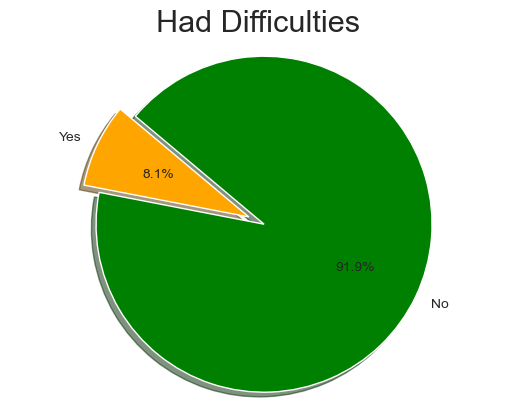

In [63]:
labels = 'Yes', 'No',
sizes = [(df_app.loc[df_app['TARGET']==1].shape[0] / df_app.shape[0])*100, 100-(df_app.loc[df_app['TARGET']==1].shape[0] / df_app.shape[0])*100]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140, colors=['orange', 'g'])
ax1.axis('equal')

plt.title('Had Difficulties', size=22)

plt.show()

##### 1.2) DISTRIBUTION of **GENDER**

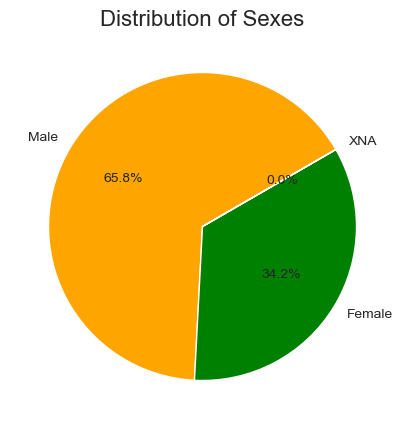

In [64]:
plt.figure(figsize=(5,5))
plt.pie(df_app['CODE_GENDER'].value_counts().tolist(), labels=['Male', 'Female', 'XNA'],
        colors=['orange', 'green'], autopct='%1.1f%%', startangle=30)
plt.title('Distribution of Sexes', size=16)
plt.show()

##### 1.3) **AMT** Variables

* **AMT_ANNUITY**: Loan annuity;
* **AMT_CREDIT**: Credit amount of the loan;
* **AMT_GOODS_PRICE**: For consumer loans it is the price of the goods for which the loan is given;
* **AMT_INCOME_TOTAL**: Income of the client.

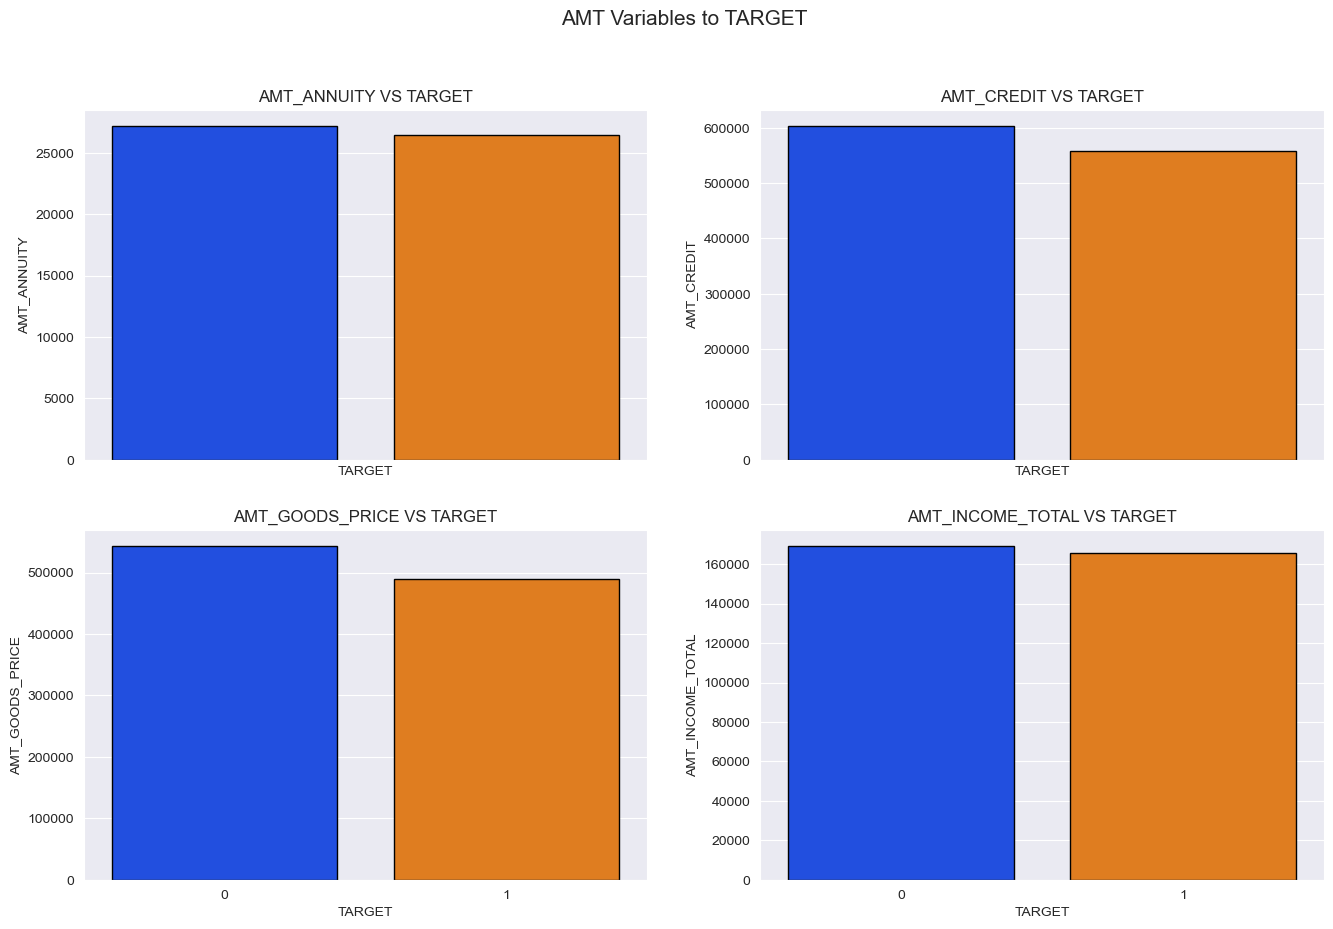

In [65]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,10))
sns.barplot(ax=axes[0,0], x=df_app["TARGET"],y=df_app["AMT_ANNUITY"],ci=None, edgecolor="black", palette="bright")
axes[0,0].set_title("AMT_ANNUITY VS TARGET")

sns.barplot(ax=axes[0,1], x=df_app["TARGET"],y=df_app["AMT_CREDIT"],ci=None, edgecolor="black", palette="bright")
axes[0,1].set_title("AMT_CREDIT VS TARGET")

sns.barplot(ax=axes[1,0], x=df_app["TARGET"],y=df_app["AMT_GOODS_PRICE"],ci=None, edgecolor="black", palette="bright")
axes[1,0].set_title("AMT_GOODS_PRICE VS TARGET")

sns.barplot(ax=axes[1,1], x=df_app["TARGET"],y=df_app["AMT_INCOME_TOTAL"],ci=None, edgecolor="black", palette="bright")
axes[1,1].set_title("AMT_INCOME_TOTAL VS TARGET")
plt.suptitle("AMT Variables to TARGET", size=15)
plt.show()

* Seems there is a little average difference between TARGET groups with regard to AMD groups.

##### 1.4) **CNT** Variables

* **CNT_CHILDREN**: Number of children the client has
* **CNT_FAM_MEMBERS**: How many family members does client have

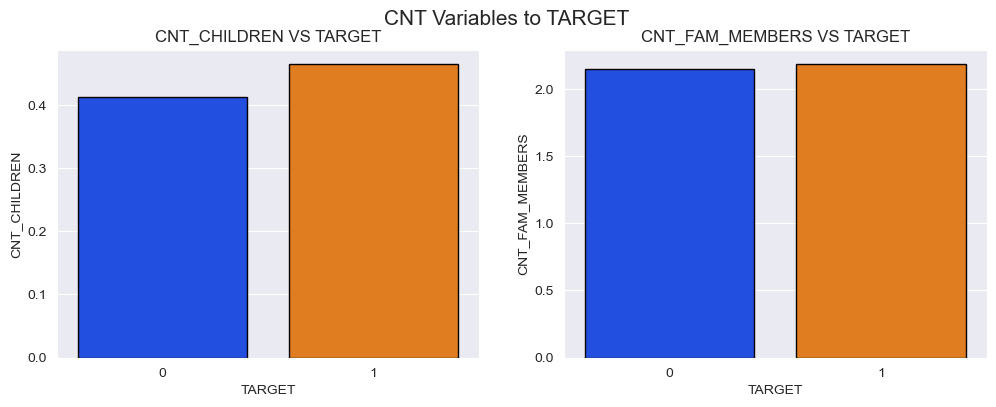

In [66]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,4))
# fig.suptitle('AMT Variables to TARGET')
sns.barplot(ax=axes[0], x=df_app["TARGET"],y=df_app["CNT_CHILDREN"],ci=None, edgecolor="black", palette="bright")
axes[0].set_title("CNT_CHILDREN VS TARGET")

sns.barplot(ax=axes[1], x=df_app["TARGET"],y=df_app["CNT_FAM_MEMBERS"],ci=None, edgecolor="black", palette="bright")
axes[1].set_title("CNT_FAM_MEMBERS VS TARGET")
plt.suptitle("CNT Variables to TARGET", size=15)
plt.show()

* As graph shows, applicants with more children and more family members are more likely to have payment difficulties.

##### 1.5) **DAYS** Variables

* **DAYS_BIRTH**: Client's age in days at the time of application
* **DAYS_EMPLOYED**: How many days before the application the person started current employment
* **DAYS_ID_PUBLISH**: How many days before the application did client change the identity document with which he applied for the loan
* **DAYS_LAST_PHONE_CHANGE**: How many days before application did client change phone
* **DAYS_REGISTRATION**: How many days before the application did client change his registration

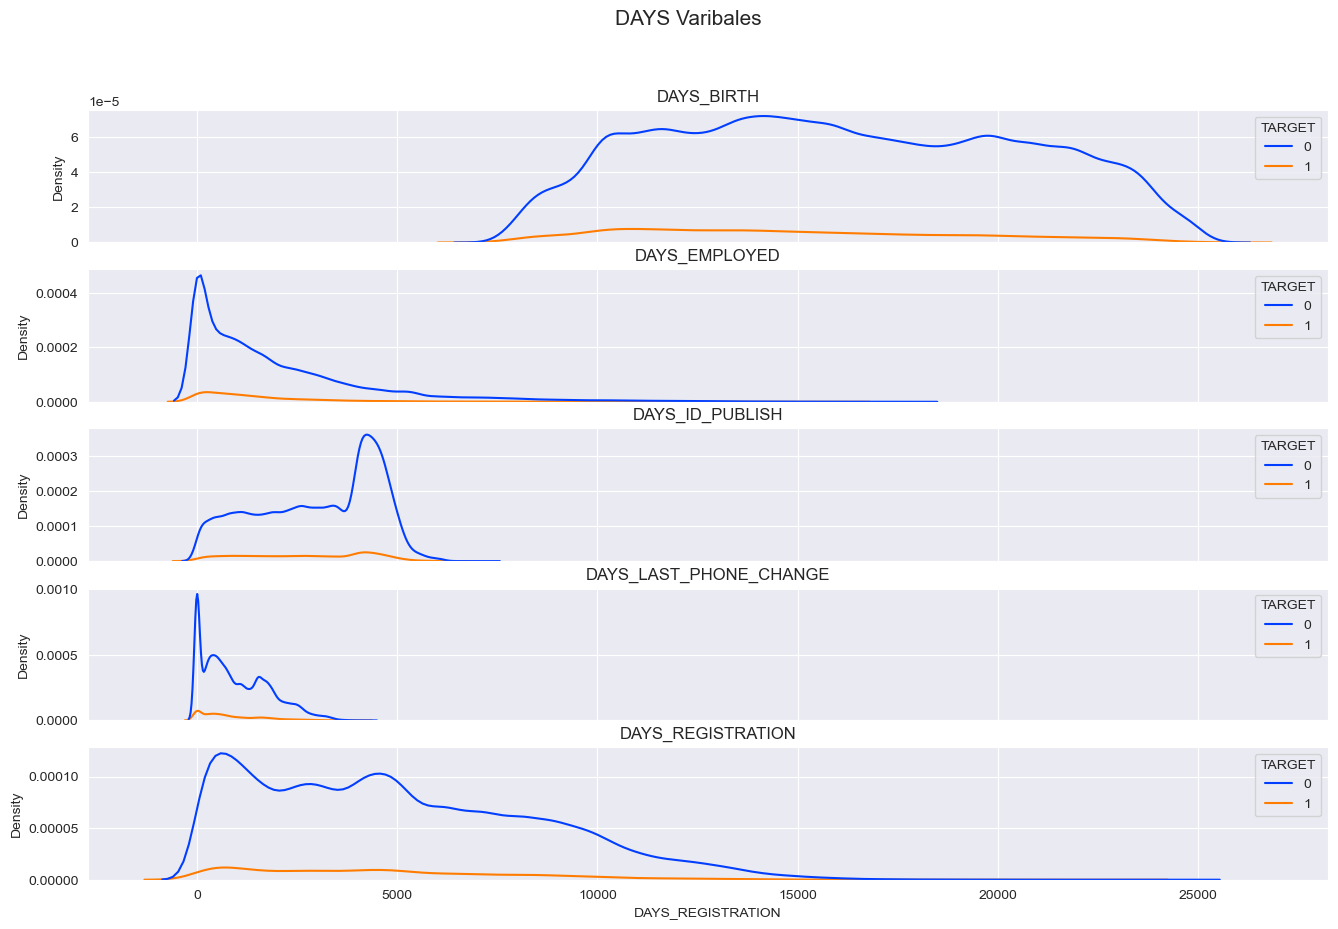

In [67]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(16,10))
# fig.suptitle('AMT Variables to TARGET')
sns.kdeplot(ax=axes[0], hue=df_app["TARGET"],x=df_app["DAYS_BIRTH"], palette="bright")
axes[0].set_title("DAYS_BIRTH")

sns.kdeplot(ax=axes[1], hue=df_app["TARGET"],x=df_app["DAYS_EMPLOYED"], palette="bright")
axes[1].set_title("DAYS_EMPLOYED")

sns.kdeplot(ax=axes[2], hue=df_app["TARGET"],x=df_app["DAYS_ID_PUBLISH"], palette="bright")
axes[2].set_title("DAYS_ID_PUBLISH")

sns.kdeplot(ax=axes[3], hue=df_app["TARGET"],x=df_app["DAYS_LAST_PHONE_CHANGE"], palette="bright")
axes[3].set_title("DAYS_LAST_PHONE_CHANGE")

sns.kdeplot(ax=axes[4], hue=df_app["TARGET"],x=df_app["DAYS_REGISTRATION"], palette="bright")
axes[4].set_title("DAYS_REGISTRATION")

plt.suptitle("DAYS Varibales", size=15)
plt.show()

Seems there are still many outliers in these variables but removing them should not be appropriate (removing about 20% of observations for each column probably would be too much), so firtly let's see how outlier-robust models will work on them.

##### 1.6) **DEF/OBS** Variables

* **DEF_30_CNT_SOCIAL_CIRCLE**: How many observation of client's social surroundings defaulted on 30 DPD (days past due)
* **OBS_30_CNT_SOCIAL_CIRCLE**: How many observation of client's social surroundings with observable 30 DPD (days past due) default
* **DEF_60_CNT_SOCIAL_CIRCLE**: How many observation of client's social surroundings with observable 60 DPD (days past due) default
* **OBS_60_CNT_SOCIAL_CIRCLE**: How many observation of client's social surroundings defaulted on 60 (days past due) DPD

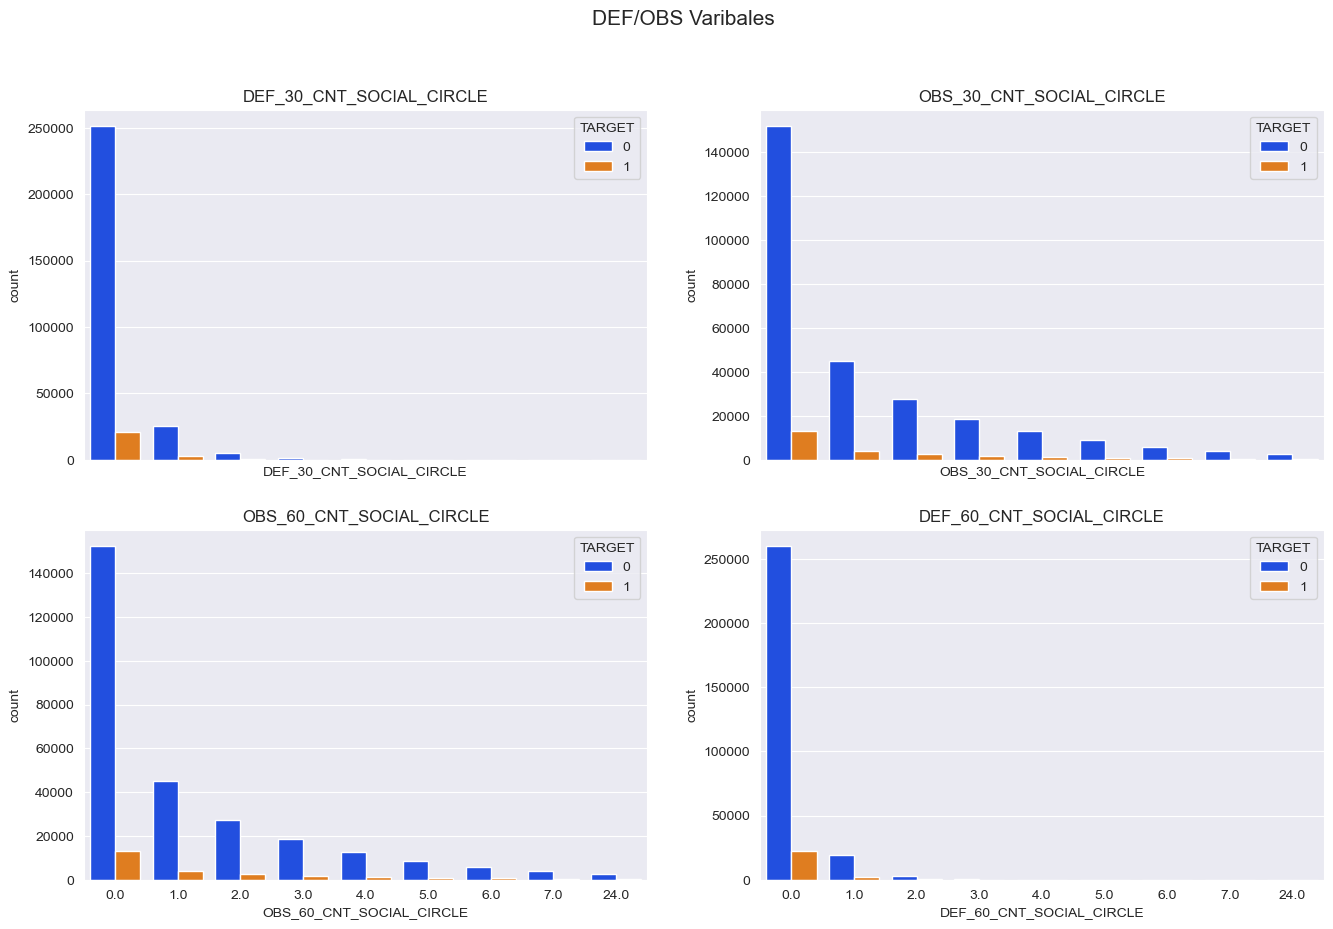

In [68]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,10))
sns.countplot(ax=axes[0,0], hue=df_app["TARGET"],x=df_app["DEF_30_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[0,0].set_title("DEF_30_CNT_SOCIAL_CIRCLE")

sns.countplot(ax=axes[0,1], hue=df_app["TARGET"],x=df_app["OBS_30_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[0,1].set_title("OBS_30_CNT_SOCIAL_CIRCLE")

sns.countplot(ax=axes[1,0], hue=df_app["TARGET"],x=df_app["OBS_60_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[1,0].set_title("OBS_60_CNT_SOCIAL_CIRCLE")

sns.countplot(ax=axes[1,1], hue=df_app["TARGET"],x=df_app["DEF_60_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[1,1].set_title("DEF_60_CNT_SOCIAL_CIRCLE")

plt.suptitle("DEF/OBS Varibales", size=15)
plt.show()

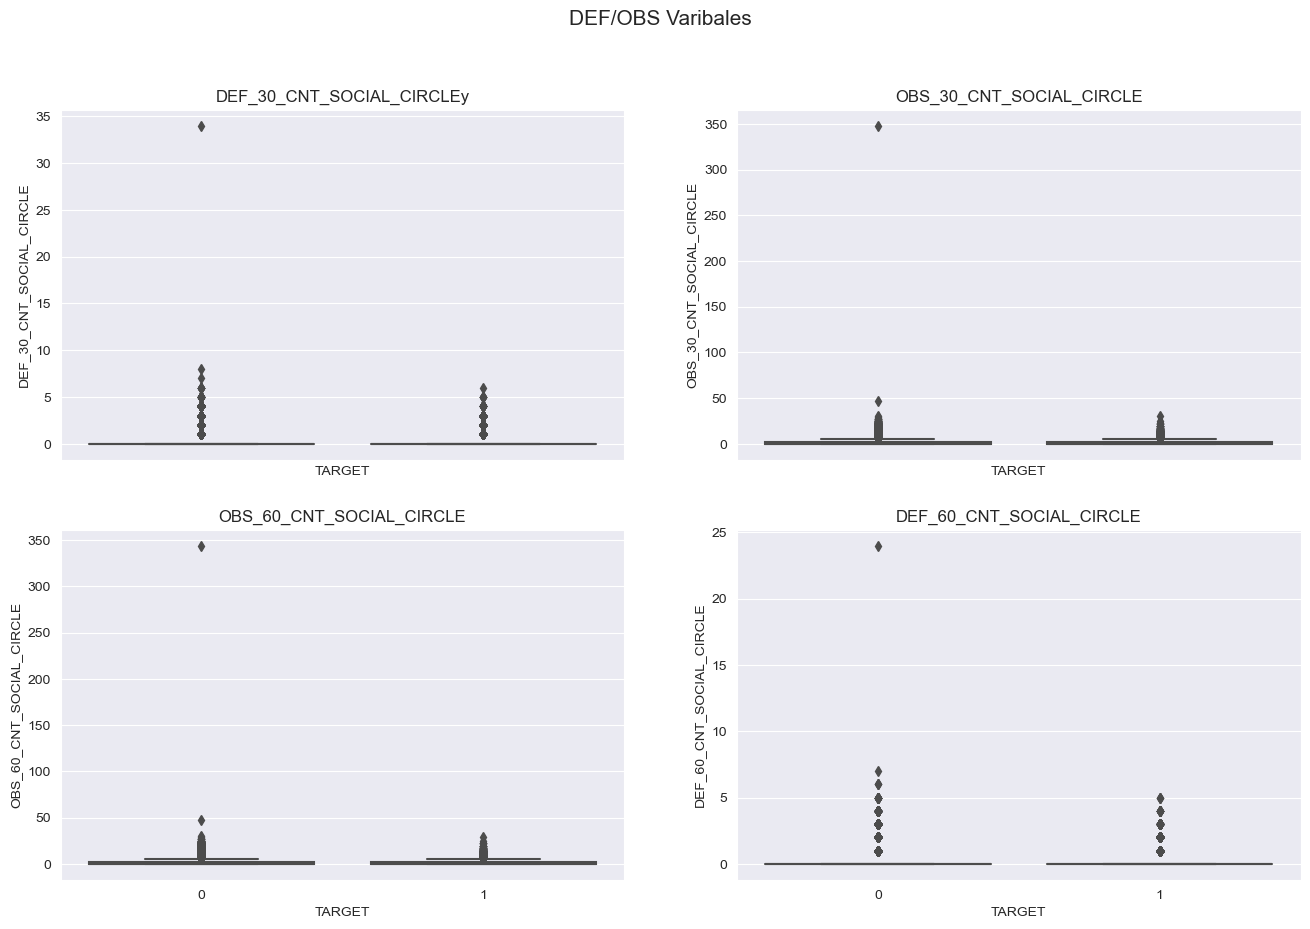

In [69]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(16,10))
# fig.suptitle('AMT Variables to TARGET')
sns.boxplot(ax=axes[0,0],x=df_app["TARGET"],y=df_app["DEF_30_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[0,0].set_title("DEF_30_CNT_SOCIAL_CIRCLEy")

sns.boxplot(ax=axes[0,1], x=df_app["TARGET"],y=df_app["OBS_30_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[0,1].set_title("OBS_30_CNT_SOCIAL_CIRCLE")

sns.boxplot(ax=axes[1,0], x=df_app["TARGET"],y=df_app["OBS_60_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[1,0].set_title("OBS_60_CNT_SOCIAL_CIRCLE")

sns.boxplot(ax=axes[1,1], x=df_app["TARGET"],y=df_app["DEF_60_CNT_SOCIAL_CIRCLE"], palette="bright")
axes[1,1].set_title("DEF_60_CNT_SOCIAL_CIRCLE")

plt.suptitle("DEF/OBS Varibales", size=15)
plt.show()

* Seems these variables are cocentrated between [0;1] interval

##### 1.7) **FLAG** Variables

* **FLAG_CONT_MOBILE**: Was mobile phone reachable (1=YES, 0=NO)
* **FLAG_EMAIL**: Did client provide email (1=YES, 0=NO)
* **FLAG_EMP_PHONE**: Did client provide work phone (1=YES, 0=NO)
* **FLAG_MOBIL**: Did client provide mobile phone (1=YES, 0=NO)
* **FLAG_OWN_CAR**: Flag if the client owns a car
* **FLAG_OWN_REALTY**: Flag if client owns a house or flat
* **FLAG_PHONE**: Did client provide home phone (1=YES, 0=NO)
* **FLAG_WORK_PHONE**: Did client provide home phone (1=YES, 0=NO)

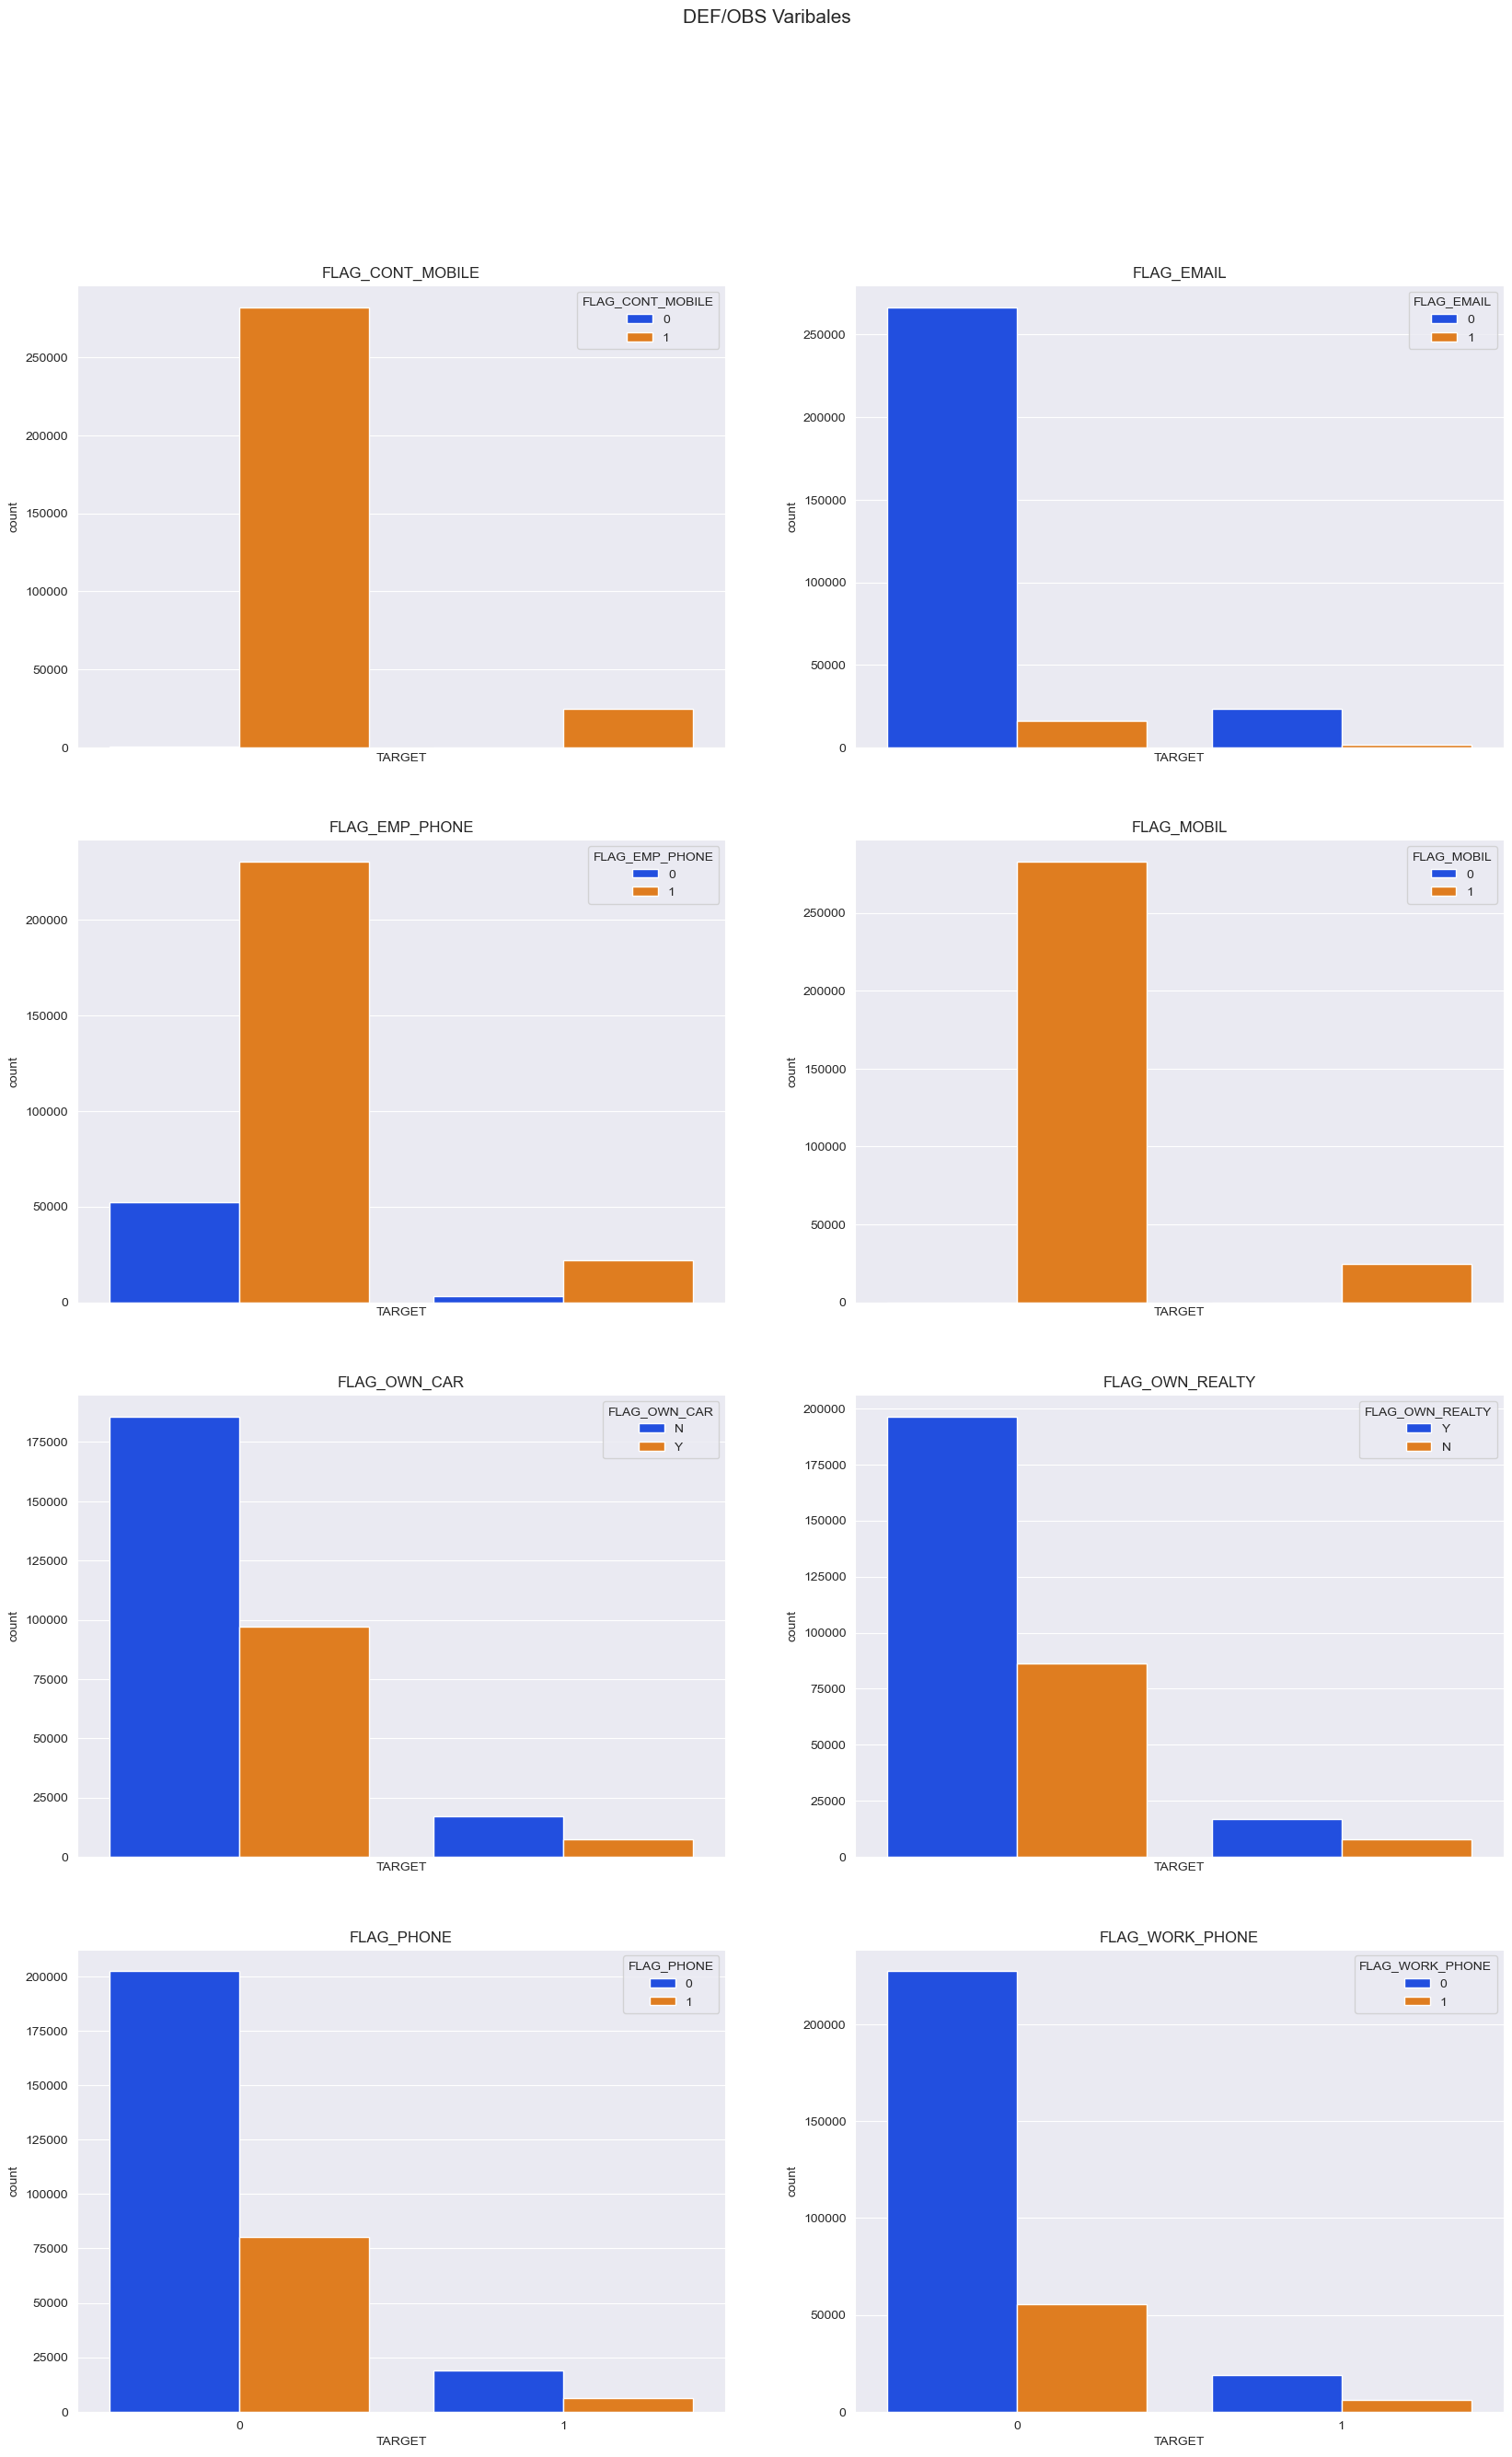

In [70]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(20,30))
sns.countplot(ax=axes[0,0],x=df_app["TARGET"],hue=df_app["FLAG_CONT_MOBILE"], palette="bright")
axes[0,0].set_title("FLAG_CONT_MOBILE")

sns.countplot(ax=axes[0,1], x=df_app["TARGET"],hue=df_app["FLAG_EMAIL"], palette="bright")
axes[0,1].set_title("FLAG_EMAIL")

sns.countplot(ax=axes[1,0], x=df_app["TARGET"],hue=df_app["FLAG_EMP_PHONE"], palette="bright")
axes[1,0].set_title("FLAG_EMP_PHONE")

sns.countplot(ax=axes[1,1], x=df_app["TARGET"],hue=df_app["FLAG_MOBIL"], palette="bright")
axes[1,1].set_title("FLAG_MOBIL")

sns.countplot(ax=axes[2,0], x=df_app["TARGET"],hue=df_app["FLAG_OWN_CAR"], palette="bright")
axes[2,0].set_title("FLAG_OWN_CAR")

sns.countplot(ax=axes[2,1], x=df_app["TARGET"],hue=df_app["FLAG_OWN_REALTY"], palette="bright")
axes[2,1].set_title("FLAG_OWN_REALTY")

sns.countplot(ax=axes[3,0], x=df_app["TARGET"],hue=df_app["FLAG_PHONE"], palette="bright")
axes[3,0].set_title("FLAG_PHONE")

sns.countplot(ax=axes[3,1], x=df_app["TARGET"],hue=df_app["FLAG_WORK_PHONE"], palette="bright")
axes[3,1].set_title("FLAG_WORK_PHONE")

plt.suptitle("DEF/OBS Varibales", size=15)
plt.show()

##### 1.8) **FLAG_DOCUMENT** Variables

* **FLAG_DOCUMENT_X**: did client provide document X

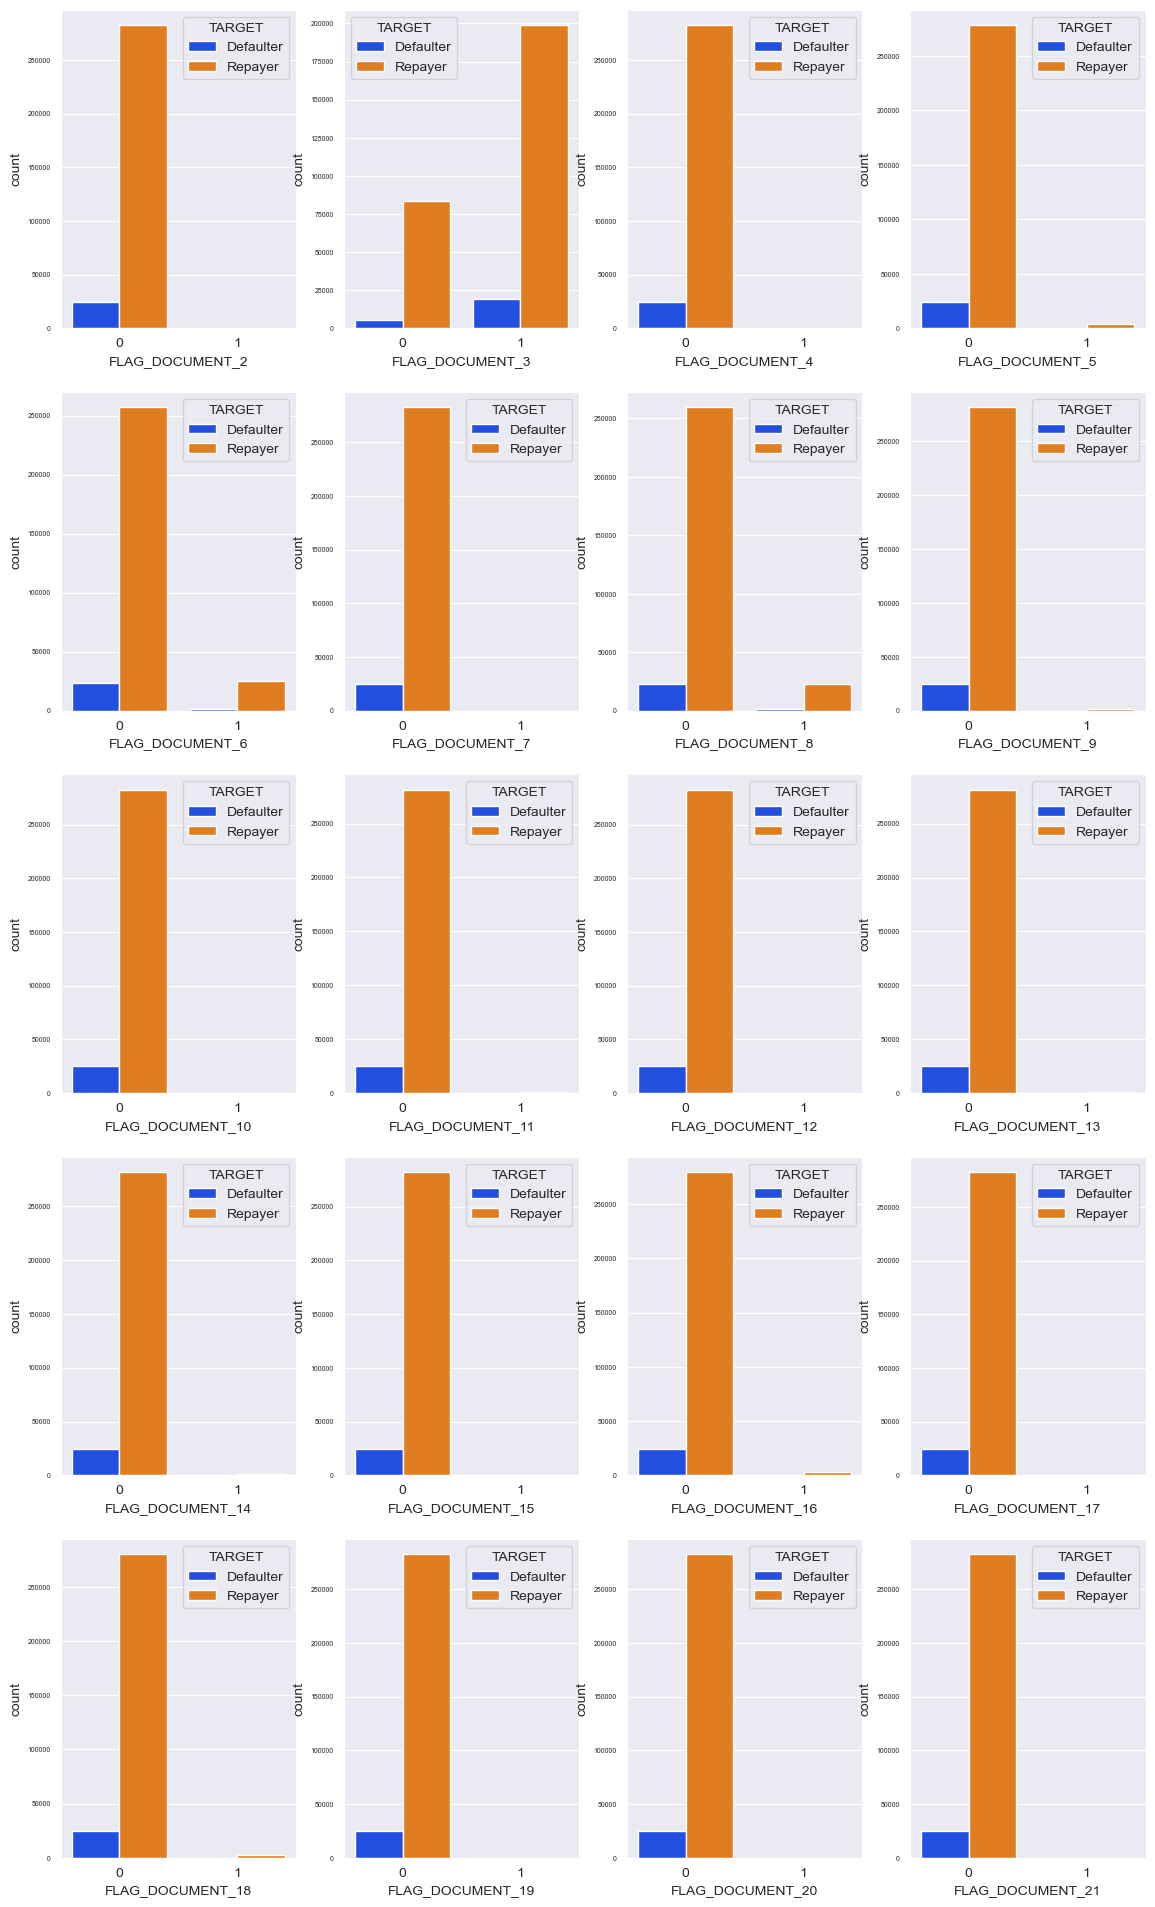

In [71]:
flagdoc_cols= ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
               'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
               'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
               'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
               'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
               'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
               'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

df_flag = df_app[flagdoc_cols+["TARGET"]].copy()

length = len(flagdoc_cols)

df_flag["TARGET"] = df_flag["TARGET"].replace({1:"Defaulter",0:"Repayer"})

fig = plt.figure(figsize=(14,24))
for i,j in itertools.zip_longest(flagdoc_cols,range(length)):
    plt.subplot(5,4,j+1)
    ax = sns.countplot(x=df_flag[i],hue=df_flag["TARGET"], palette="bright")
    plt.yticks(fontsize=5)

* Seems only valuable variable here is **FLAG_DOCUMENT_3**: other do not have any explanatory power so dropping them would be right choice.

##### 1.9) **HOUR_APPR_PROCESS_START**/**WEEKDAY_APPR_PROCESS_START**

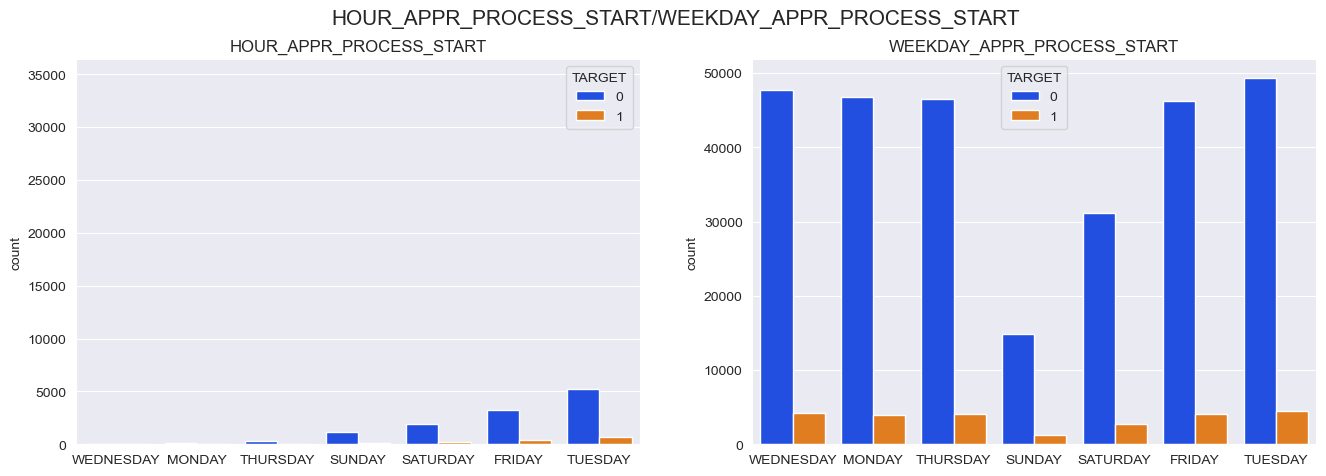

In [72]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,5))

sns.countplot(ax=axes[0], hue=df_app["TARGET"],x=df_app["HOUR_APPR_PROCESS_START"], palette="bright")
axes[0].set_title("HOUR_APPR_PROCESS_START")
axes[0].set_xlabel("")

sns.countplot(ax=axes[1], hue=df_app["TARGET"],x=df_app["WEEKDAY_APPR_PROCESS_START"], palette="bright")
axes[1].set_title("WEEKDAY_APPR_PROCESS_START")
axes[1].set_xlabel("")

plt.suptitle("HOUR_APPR_PROCESS_START/WEEKDAY_APPR_PROCESS_START", size=15)
plt.show()

##### 1.10) NAME Variables

* **NAME_CONTRACT_TYPE**: Identification if loan is cash or revolving
* **NAME_EDUCATION_TYPE**: Level of highest education the client achieved
* **NAME_FAMILY_STATUS**: Family status of the client
* **NAME_HOUSING_TYPE**: What is the housing situation of the client (renting, living with parents, ...)
* **NAME_INCOME_TYPE**: Clients income type (businessman, working, maternity leave,…)
* **NAME_TYPE_SUITE**: Who was accompanying client when he was applying for the loan

* Firtly lets see distribution of loan: whether it is **cash** or **revolving**

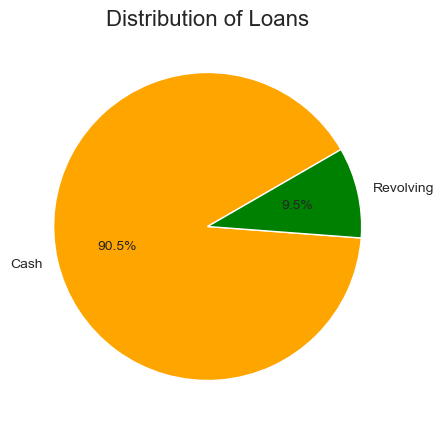

In [73]:
plt.figure(figsize=(5,5))
plt.pie(df_app['NAME_CONTRACT_TYPE'].value_counts().tolist(), labels=['Cash', 'Revolving'],
        colors=['orange', 'green'], autopct='%1.1f%%', startangle=30)
plt.title('Distribution of Loans', size=16)
plt.show()

* Now let's check whether default rate differes via NAME features

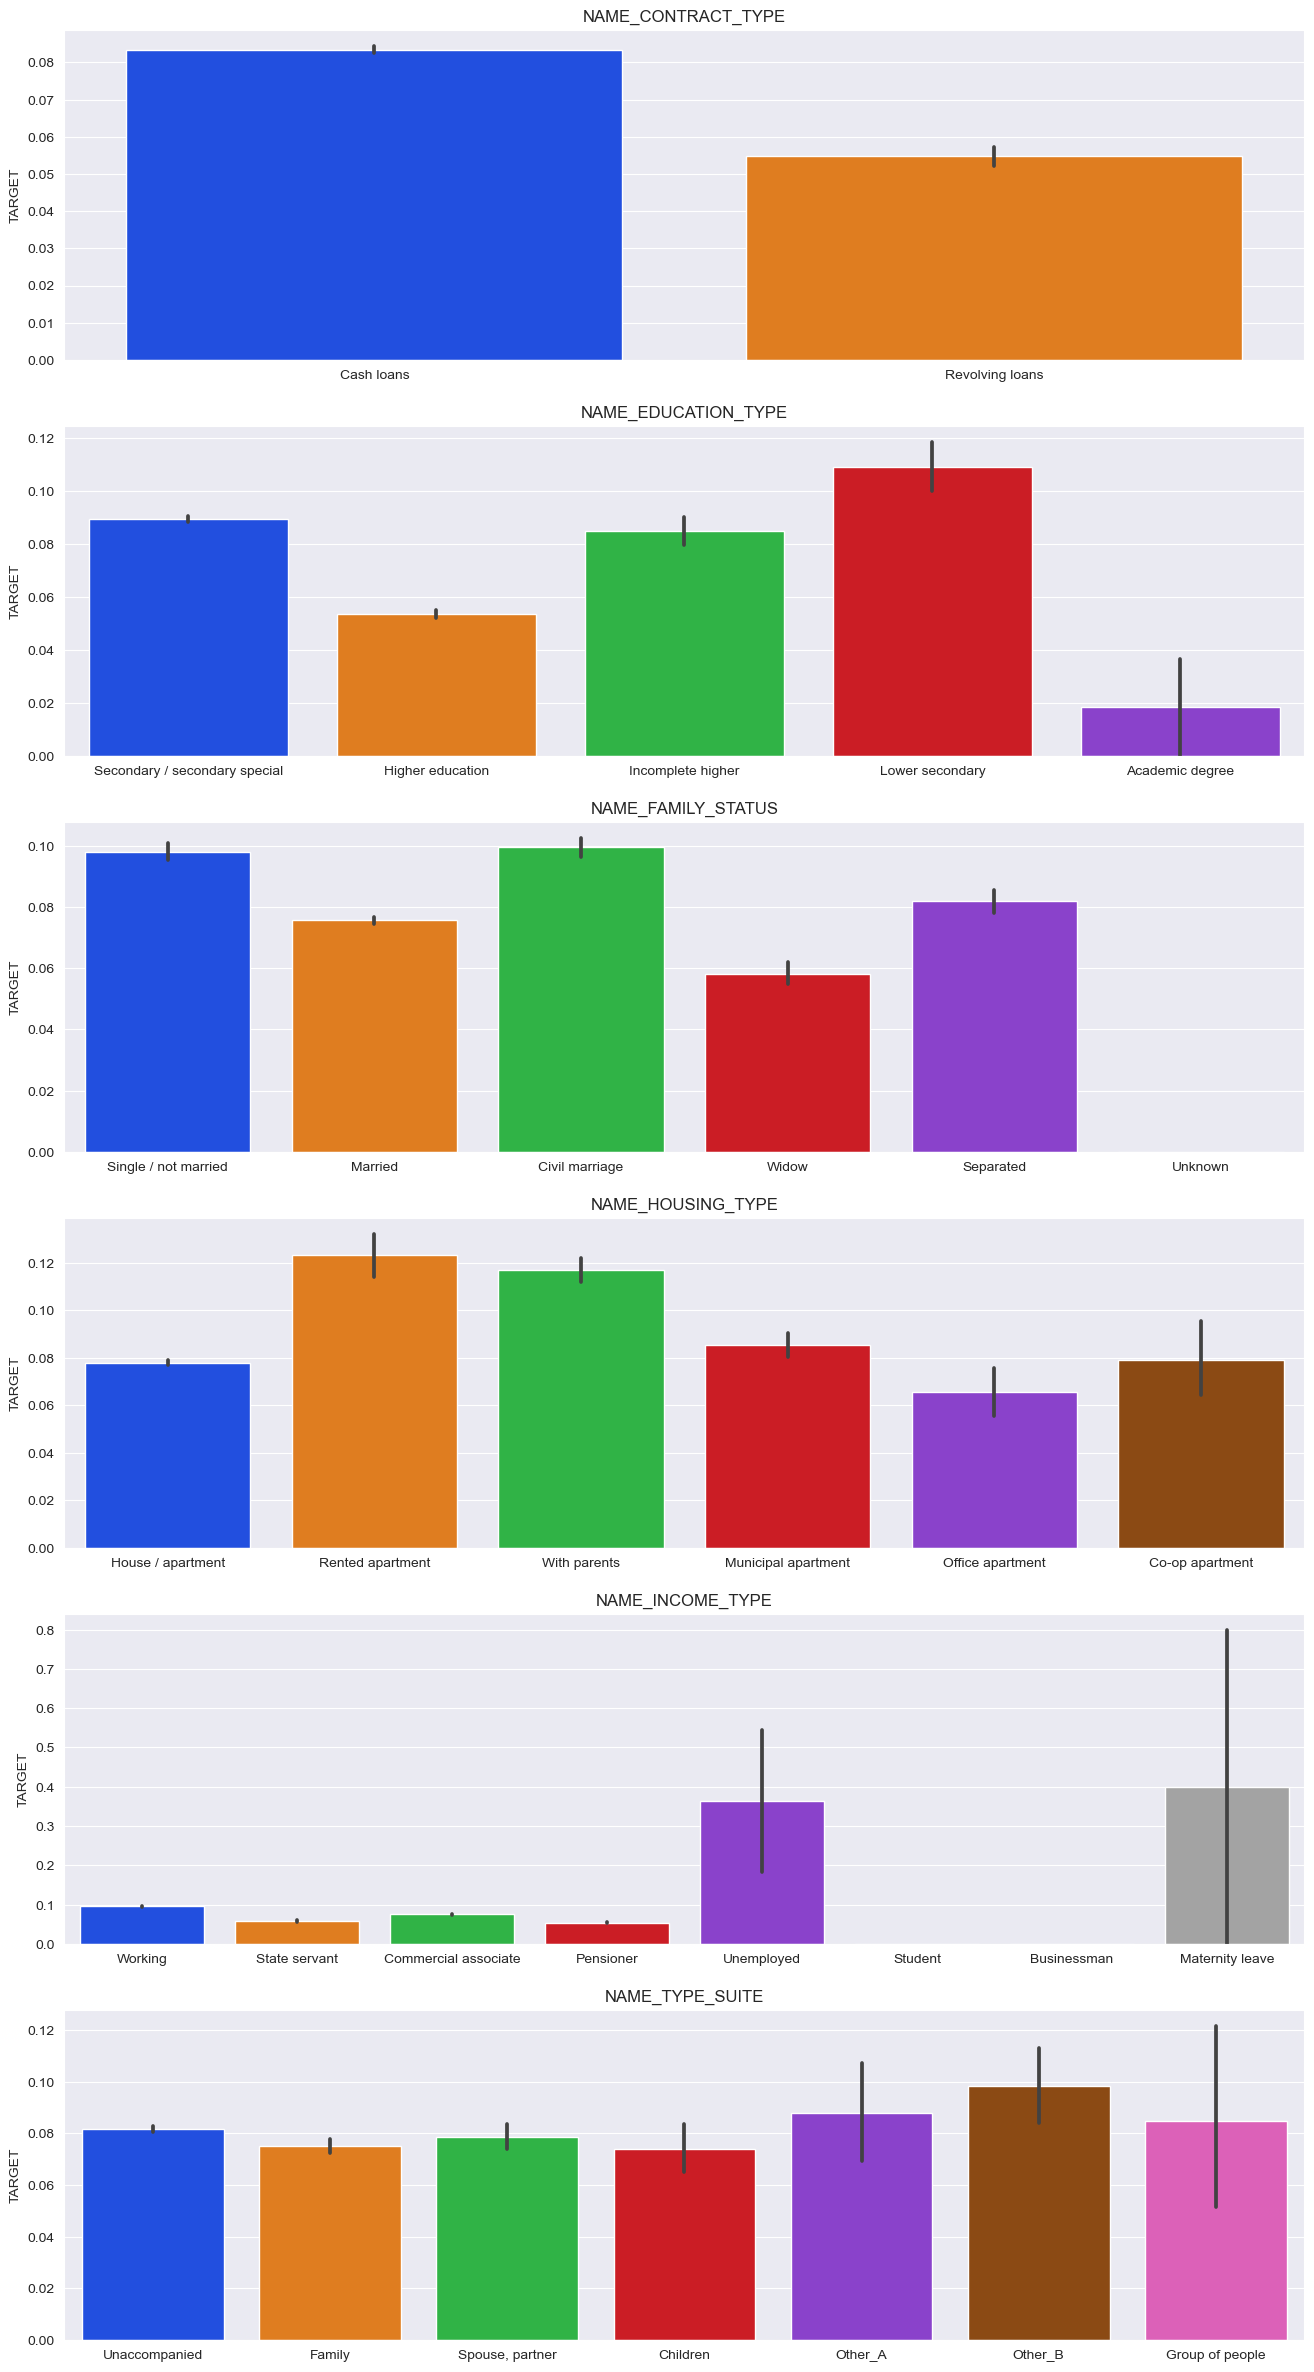

In [74]:
name_cols= ['NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
               'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE']

df_name_cols = df_app[name_cols+["TARGET"]].copy()

length = len(name_cols)

fig = plt.figure(figsize=(16,30))
for i,j in itertools.zip_longest(name_cols,range(length)):
    plt.subplot(6,1,j+1)
    ax = sns.barplot(x=df_name_cols[i],y=df_name_cols["TARGET"], palette="bright")
    plt.yticks(fontsize=10)
    plt.xlabel("")
    plt.title(i)

These barplots show average payment problem's with differenct classes. These graph shows following findings:
* There are more peyment problems with cash loans rather than revolving loans;
* People with higher education are less likely to have problems with payment;
* Consumers who live with parent or rented appartment are more likely to have payment problems;
* Unemloyeed and Maternity leave consumers are very likely to have problems with payment;
* Class of accompanying person does not affect payment problems much: variation increases as  we move more informal accompanying person class but average do not differ much.

##### 1.11) **OCCUPATION_TYPE**/**ORGANIZATION_TYPE**

* **OCCUPATION_TYPE**: What kind of occupation does the client have
* **ORGANIZATION_TYPE**: Type of organization where client works	

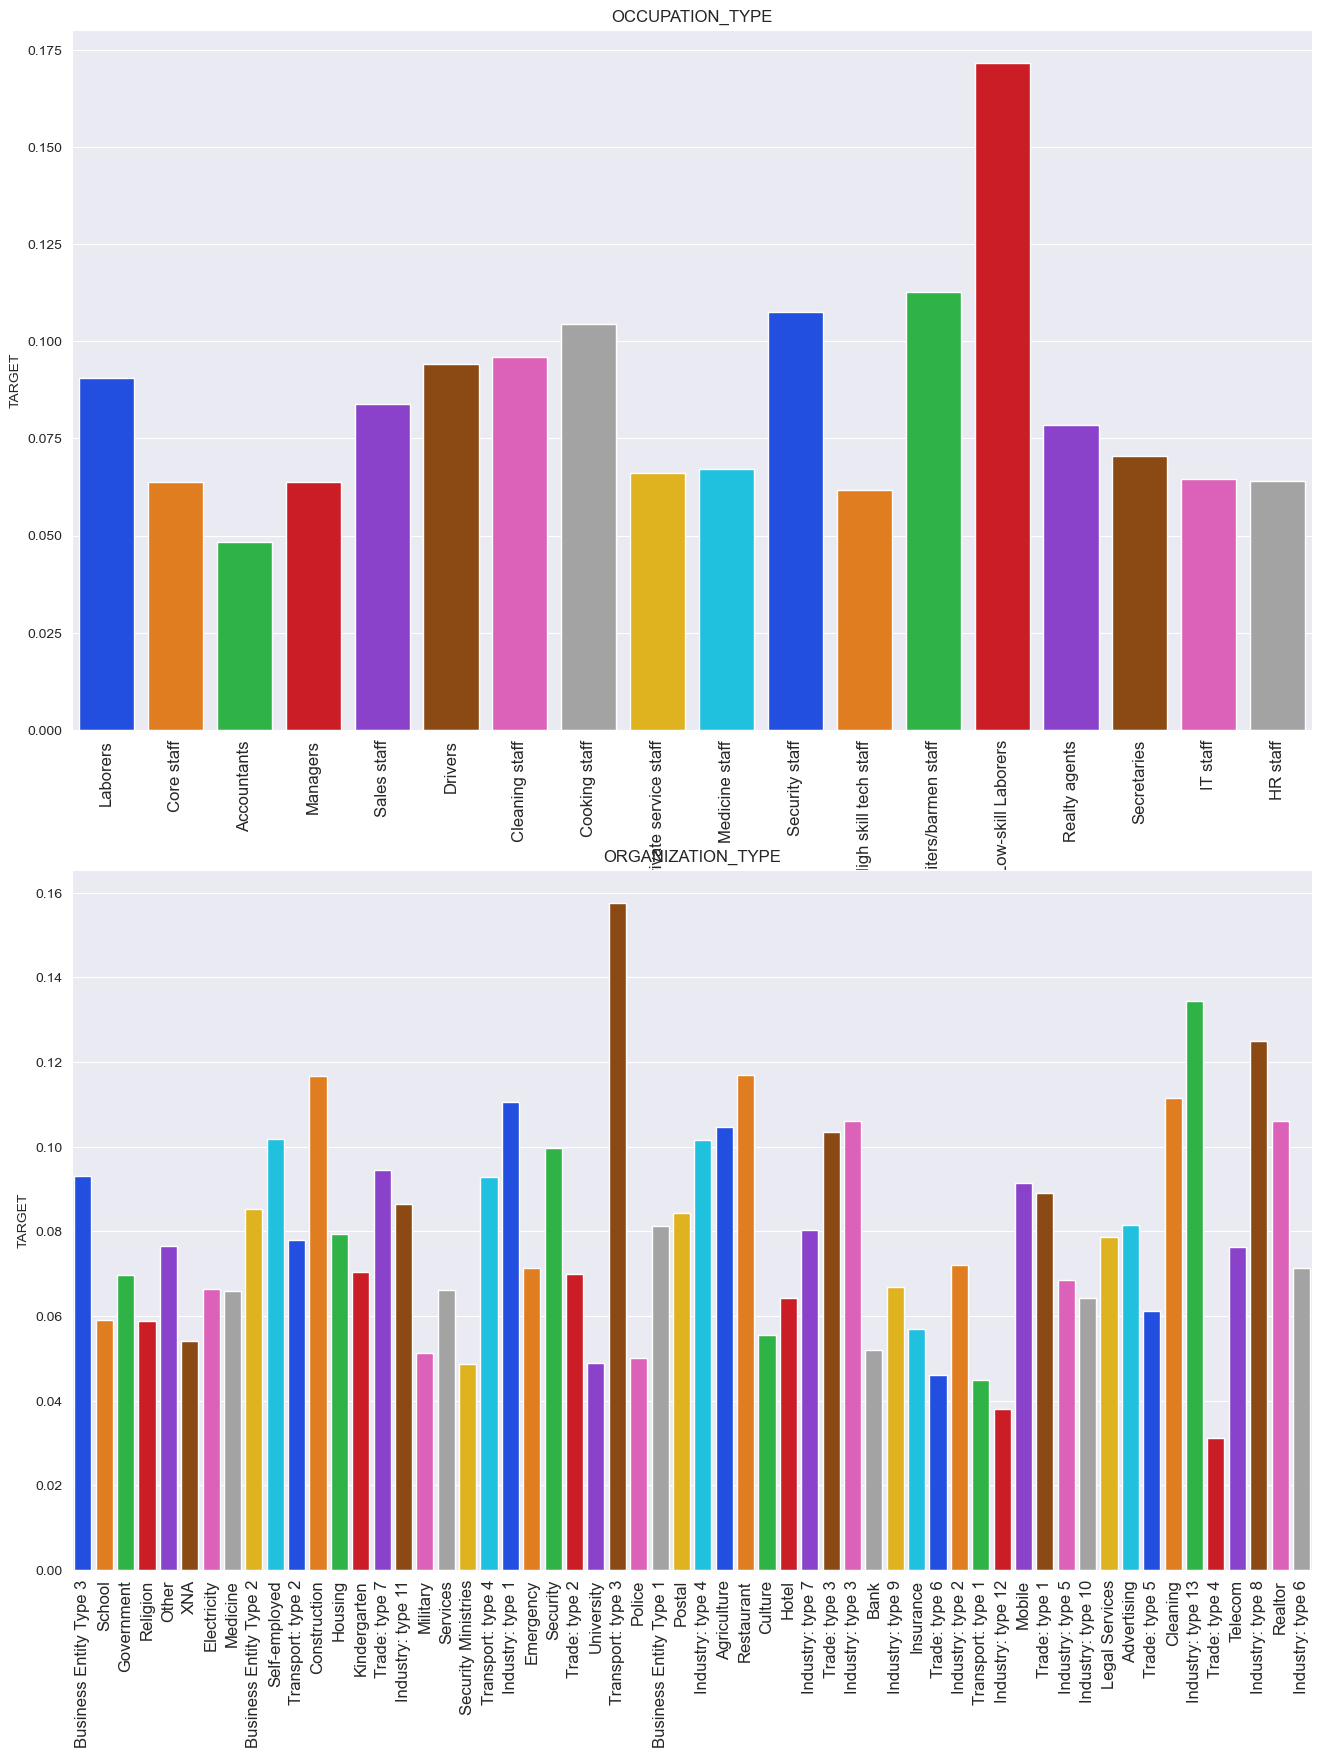

In [75]:
type_cols= ["OCCUPATION_TYPE", 'ORGANIZATION_TYPE']

df_type_cols = df_app[type_cols+["TARGET"]].copy()

length = len(type_cols)

fig = plt.figure(figsize=(16,20))
for i,j in itertools.zip_longest(type_cols,range(length)):
    plt.subplot(2,1,j+1)
    ax = sns.barplot(x=df_type_cols[i],y=df_type_cols["TARGET"], palette="bright", ci=False)
    plt.yticks(fontsize=10)
    plt.xticks(rotation='vertical', size=12)
    plt.xlabel("")
    plt.title(i)

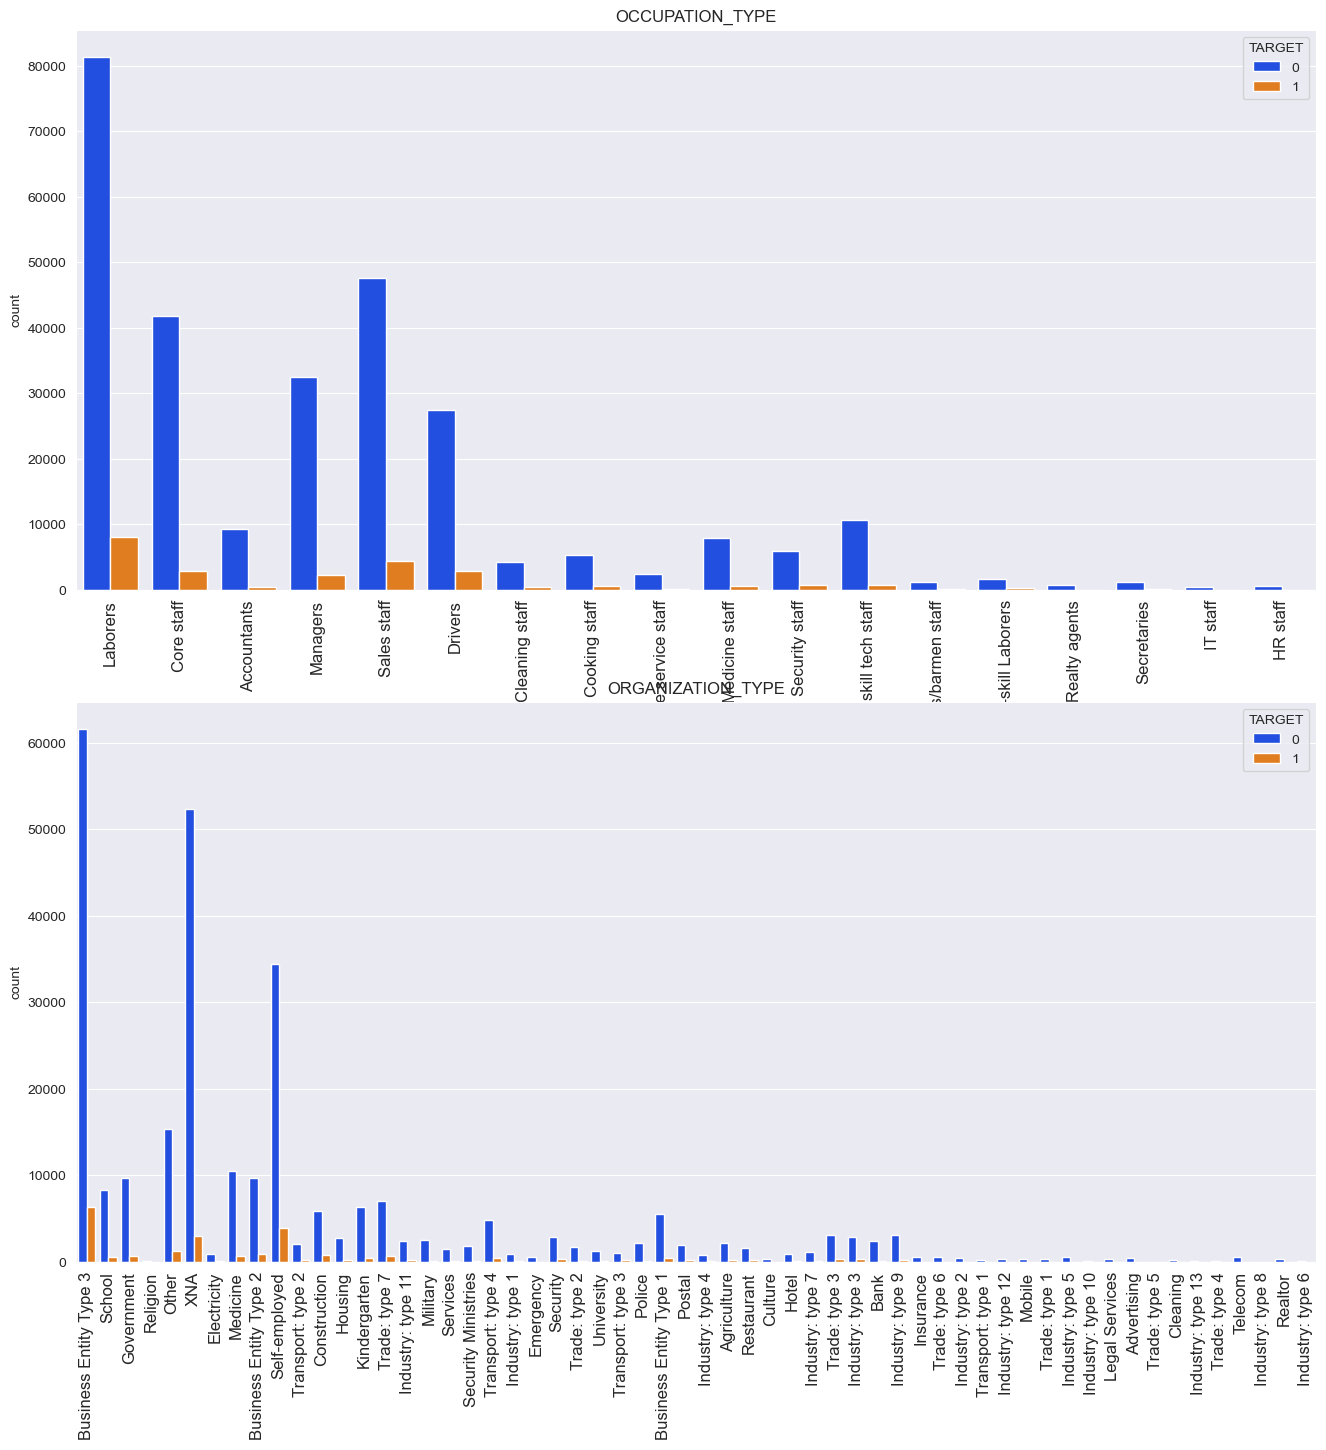

In [76]:
type_cols= ["OCCUPATION_TYPE", 'ORGANIZATION_TYPE']

df_type_cols = df_app[type_cols+["TARGET"]].copy()

length = len(type_cols)

fig = plt.figure(figsize=(16,16))
for i,j in itertools.zip_longest(type_cols,range(length)):
    plt.subplot(2,1,j+1)
    ax = sns.countplot(x=df_type_cols[i],hue=df_type_cols["TARGET"], palette="bright")
    plt.yticks(fontsize=10)
    plt.xticks(rotation='vertical', size=12)
    plt.xlabel("")
    plt.title(i)

##### 1.12) REG Variables

* **REGION_POPULATION_RELATIVE**: Normalized population of region where client lives (higher number means the client lives in more populated region);
* **REGION_RATING_CLIENT**: Our rating of the region where client lives (1,2,3);
* **REGION_RATING_CLIENT_W_CITY**: Our rating of the region where client lives with taking city into account (1,2,3);
* **REG_CITY_NOT_LIVE_CITY**: Flag if client's permanent address does not match contact address (1=different, 0=same, at city level);
* **REG_CITY_NOT_WORK_CITY**: Flag if client's permanent address does not match work address (1=different, 0=same, at city level);
* **REG_REGION_NOT_LIVE_REGION**: Flag if client's permanent address does not match contact address (1=different, 0=same, at region level);
* **REG_REGION_NOT_WORK_REGION**: Flag if client's permanent address does not match work address (1=different, 0=same, at region level).

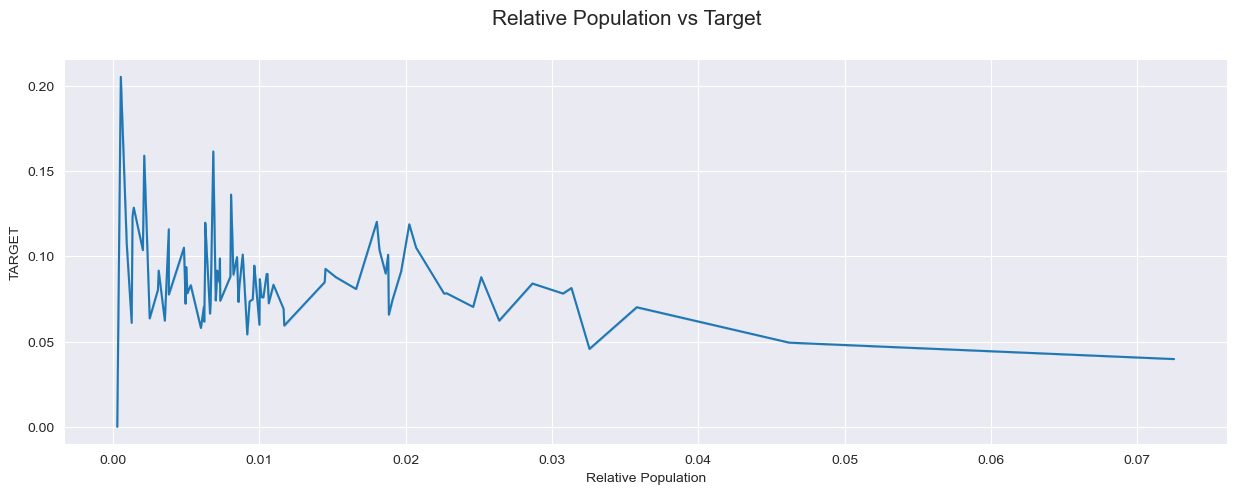

In [77]:
plt.figure(figsize=(15,5))
sns.lineplot(y=df_app["TARGET"],x=df_app["REGION_POPULATION_RELATIVE"], palette="bright", ci=False)

plt.suptitle("Relative Population vs Target", size=15)
plt.xlabel("Relative Population")
plt.show()

* Graph shows that more clients from less populated region are more likely to have problems with payment

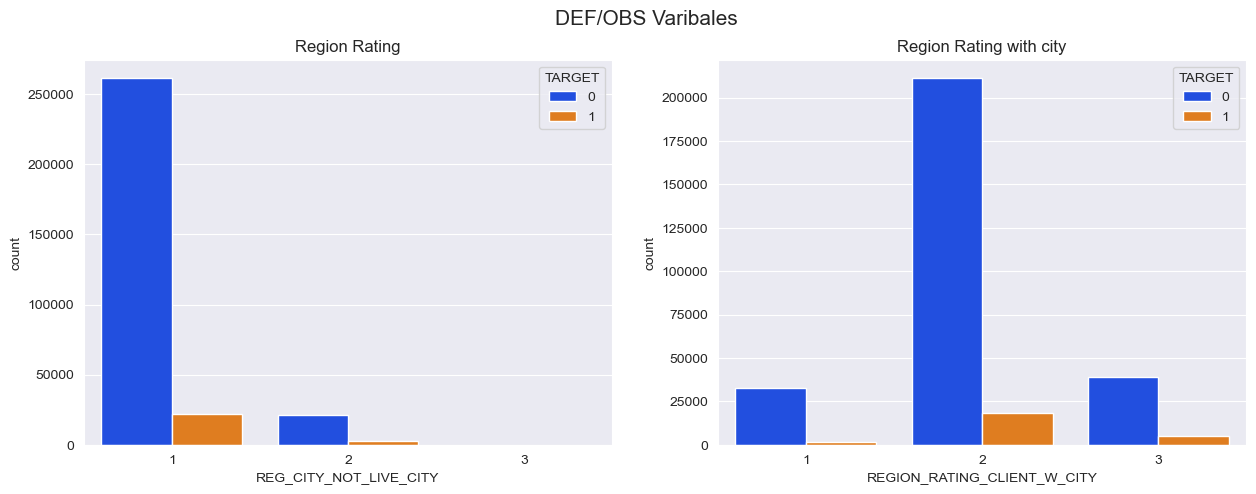

In [78]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
sns.countplot(ax=axes[0],hue=df_app["TARGET"],x=df_app["REG_CITY_NOT_LIVE_CITY"], palette="bright")
axes[0].set_title("Region Rating")

sns.countplot(ax=axes[1], hue=df_app["TARGET"],x=df_app["REGION_RATING_CLIENT_W_CITY"], palette="bright")
axes[1].set_title("Region Rating with city")

plt.suptitle("DEF/OBS Varibales", size=15)
plt.show()

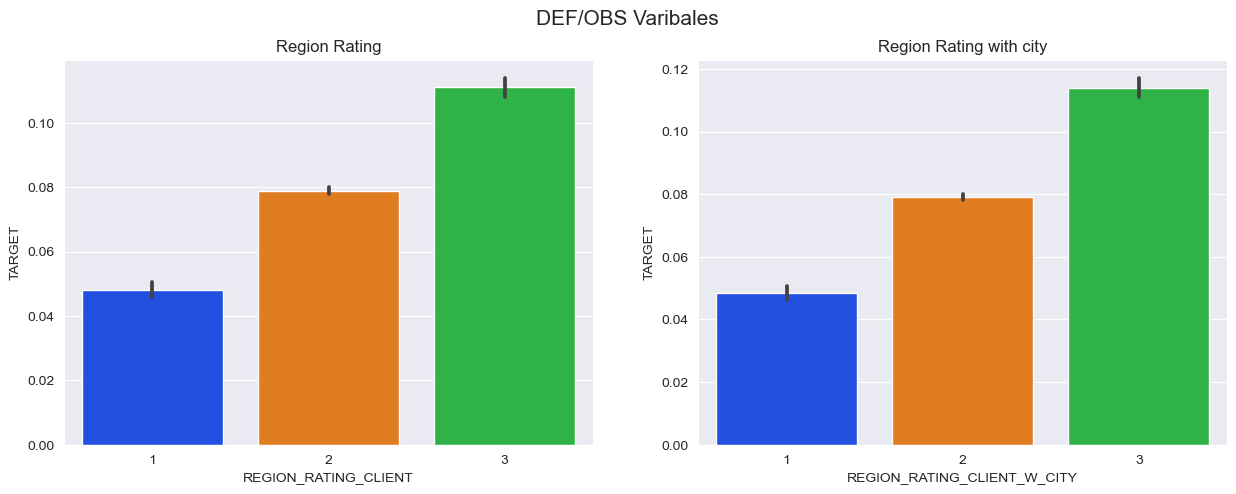

In [79]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
sns.barplot(ax=axes[0],y=df_app["TARGET"],x=df_app["REGION_RATING_CLIENT"], palette="bright")
axes[0].set_title("Region Rating")

sns.barplot(ax=axes[1], y=df_app["TARGET"],x=df_app["REGION_RATING_CLIENT_W_CITY"], palette="bright")
axes[1].set_title("Region Rating with city")

plt.suptitle("DEF/OBS Varibales", size=15)
plt.show()

* Seems payment problems increases as we move to upper classes

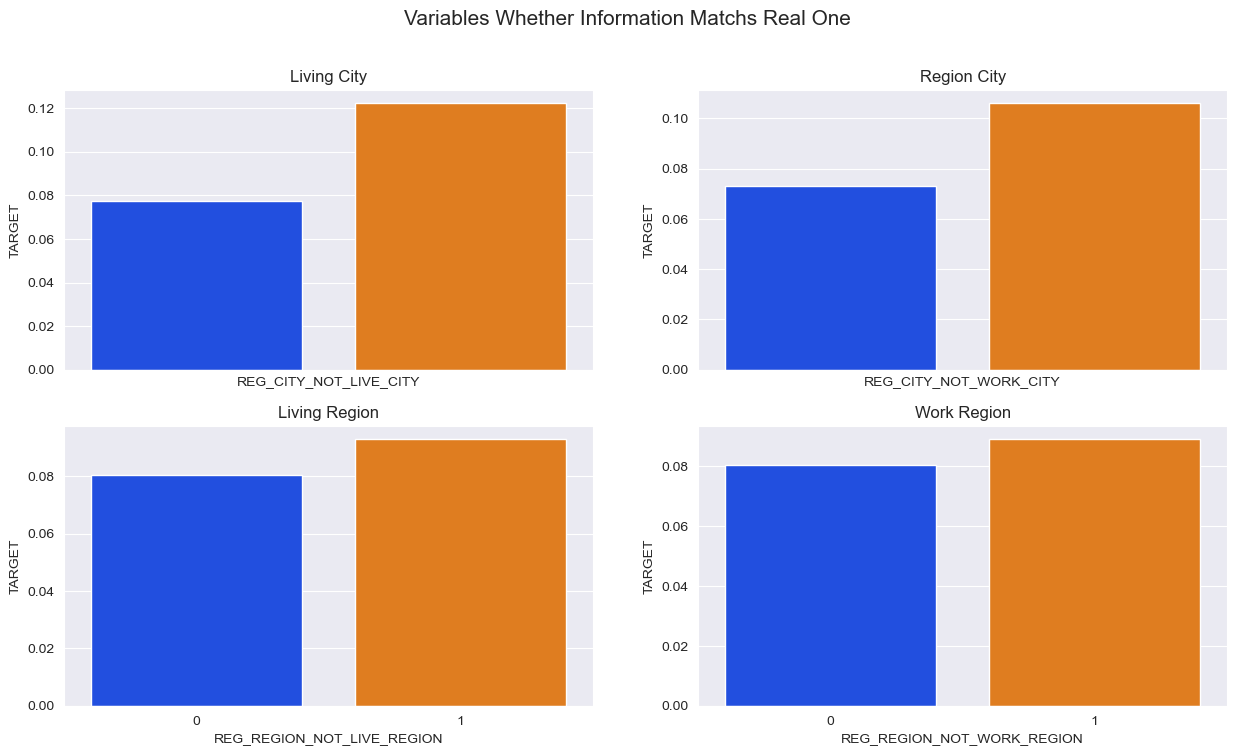

In [80]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,8))
sns.barplot(ax=axes[0,0],y=df_app["TARGET"],x=df_app["REG_CITY_NOT_LIVE_CITY"], palette="bright",ci=False)
axes[0,0].set_title("Living City")

sns.barplot(ax=axes[0,1], y=df_app["TARGET"],x=df_app["REG_CITY_NOT_WORK_CITY"], palette="bright",ci=False)
axes[0,1].set_title("Region City")

sns.barplot(ax=axes[1,0],y=df_app["TARGET"],x=df_app["REG_REGION_NOT_LIVE_REGION"], palette="bright",ci=False)
axes[1,0].set_title("Living Region")

sns.barplot(ax=axes[1,1], y=df_app["TARGET"],x=df_app["REG_REGION_NOT_WORK_REGION"], palette="bright",ci=False)
axes[1,1].set_title("Work Region")

plt.suptitle("Variables Whether Information Matchs Real One", size=15)
plt.show()

* As excpected, client's whose provided information does not match permament ones are more likely to have problems with payments

## Data Preprocessing

##### 1) Delete **FLAG_DOCUMENT_X** variables except **FLAG_DOCUMENT_3**

In [81]:
df_app.drop(columns=["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6",
                    "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10",
                    "FLAG_DOCUMENT_11", "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14",
                    "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18",
                    "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"], inplace=True)

##### 2) Generate Dummy Variables for Categorical Features

* As I plan to use non-linear models for prediction (Boosting Decision Trees), There is no need to generate N-1 dummy variable to avoid so called dummy variable trap, so I'll generate just N dummy variable for N class.

In [82]:
df_dummy = pd.get_dummies(df_app[categorical_features], drop_first=False)
df_app.drop(columns=categorical_features, inplace=True)

df = pd.concat([df_app, df_dummy], axis=1)
df_app.shape, df_dummy.shape, df.shape

((307511, 36), (307511, 124), (307511, 160))

In [83]:
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   AMT_ANNUITY                  307511 non-null  float64
 1   AMT_CREDIT                   307511 non-null  float64
 2   AMT_GOODS_PRICE              307511 non-null  float64
 3   AMT_INCOME_TOTAL             307511 non-null  float64
 4   CNT_CHILDREN                 307511 non-null  int64  
 5   CNT_FAM_MEMBERS              307511 non-null  float64
 6   DAYS_BIRTH                   307511 non-null  int64  
 7   DAYS_EMPLOYED                307511 non-null  int64  
 8   DAYS_ID_PUBLISH              307511 non-null  int64  
 9   DAYS_LAST_PHONE_CHANGE       307511 non-null  float64
 10  DAYS_REGISTRATION            307511 non-null  float64
 11  DEF_30_CNT_SOCIAL_CIRCLE     307511 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE     307511 non-null  float64
 13 

##### 3) Generate X & y Matrices

* I will generate two X & y matrices: one with varibale **EXT_SOURCE_3** for Boosting algorithms and one without it; as there is missing values in it, boosting methodes do not have problems processing it but linear models like logistic regression do not support missing values.

In [84]:
X, y = df.drop(columns="TARGET").values, df["TARGET"].values
print(X.shape, y.shape)
X2, y2 = df.drop(columns=["TARGET", "EXT_SOURCE_3"]).values, df["TARGET"].values
print(X2.shape, y2.shape)

(307511, 159) (307511,)
(307511, 158) (307511,)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=444)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=444)

In [86]:
scaler = StandardScaler()
X2_train_sc, X2_test_sc = scaler.fit_transform(X2_train), scaler.fit_transform(X2_test)

## Model Building

### Base Result

In [87]:
results = {}
sns.set_style("white")

##### Logistic Regression

In [88]:
model_lr = LogisticRegression(random_state=444, solver="saga",
                              max_iter=200)
model_lr.fit(X2_train_sc, y2_train)
y_hat_lr = model_lr.predict(X2_test_sc)

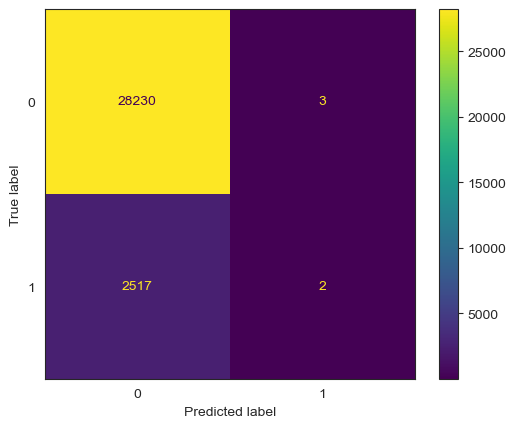

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_hat_lr))
disp.plot()
plt.show()

In [90]:
accuracy_lr = accuracy_score(y2_test, y_hat_lr)
print(f"Accuracy of Logistic Regression: {accuracy_lr:.2f}")

Accuracy of Logistic Regression: 0.92


In [91]:
report_lr = classification_report(y2_test, y_hat_lr, zero_division=0)
print(report_lr)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28233
           1       0.40      0.00      0.00      2519

    accuracy                           0.92     30752
   macro avg       0.66      0.50      0.48     30752
weighted avg       0.88      0.92      0.88     30752



##### Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
clf = DecisionTreeClassifier()


In [93]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [94]:
train_predictions = clf.predict(X_train)


In [95]:
test_predictions = clf.predict(X_test)


In [96]:
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)

# Calculate accuracy, precision, and recall on the test set
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)

print('Training Set Accuracy:', train_accuracy)
print('Training Set Precision:', train_precision)
print('Training Set Recall:', train_recall)

print('Test Set Accuracy:', test_accuracy)
print('Test Set Precision:', test_precision)
print('Test Set Recall:', test_recall)

Training Set Accuracy: 0.9197894196756022
Training Set Precision: 0.9147286821705426
Training Set Recall: 0.005290056487043845
Test Set Accuracy: 0.9175338189386056
Test Set Precision: 0.05263157894736842
Test Set Recall: 0.0003969829297340214


In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

predictions = clf.predict(X_test)

# Generate the classification report
report_clf = classification_report(y_test, predictions)

print(report_clf)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28233
           1       0.05      0.00      0.00      2519

    accuracy                           0.92     30752
   macro avg       0.49      0.50      0.48     30752
weighted avg       0.85      0.92      0.88     30752



In [98]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [99]:
print("XGB Classifier:")

# Define the parameters for the model
params = dict(
    base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
    colsample_bynode = 1, colsample_bytree = 1, gamma = 0,
    importance_type = 'gain', interaction_constraints = '',
    learning_rate = 0.3, max_delta_step = 0, max_depth = 6,
    min_child_weight = 1, missing = np.nan, monotone_constraints = '()',
    n_estimators = 500, n_jobs = -1, num_parallel_tree = 1,
    random_state = seed, reg_alpha = 0,
    reg_lambda = 1, scale_pos_weight = 10, subsample = 1,
    tree_method = 'exact', use_label_encoder = False,
    validate_parameters = 1, verbosity = None
)

model = XGBClassifier(**params)
model.fit(X_train, y_train)



XGB Classifier:


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints='()', multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, random_state=42, ...)

In [100]:
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
report_model = print(classification_report(y_test, y_pred))
print(report_model)
# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     28233
           1       0.20      0.46      0.28      2519

    accuracy                           0.81     30752
   macro avg       0.57      0.65      0.59     30752
weighted avg       0.89      0.81      0.84     30752

None
Confusion Matrix:
[[23651  4582]
 [ 1350  1169]]


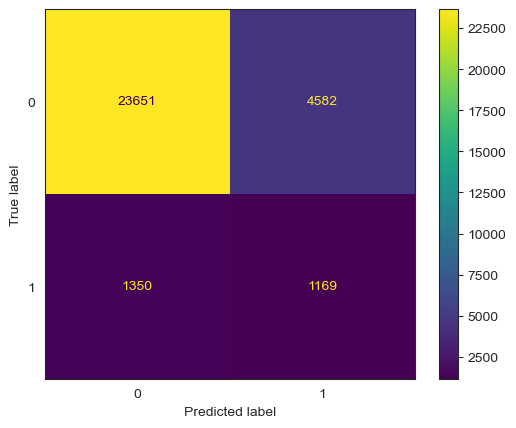

In [101]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

##### XGBoost

* Plot Top 20 important feature for XGBoost

In [102]:
import plotly.express as px

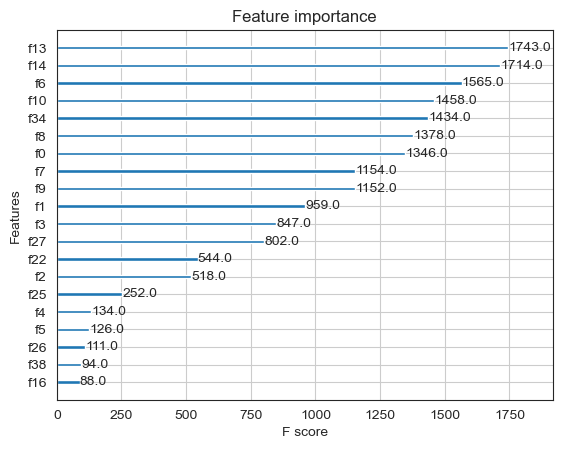

In [103]:
from xgboost import XGBClassifier, plot_importance
plot_importance(model, max_num_features=20)
plt.show()

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [105]:
nan_mask = np.isnan(X)

# Count the number of NaN values in the features array
nan_count = np.sum(nan_mask)

# Display the result
print("Number of NaN values in the features array:", nan_count)


Number of NaN values in the features array: 60965


In [106]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

In [107]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Define and train the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
("Classification Report:")
report_knn_model= classification_report(y_test, y_pred)
print(report_knn_model)

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     28233
           1       0.17      0.02      0.03      2519

    accuracy                           0.91     30752
   macro avg       0.54      0.50      0.49     30752
weighted avg       0.86      0.91      0.88     30752

Confusion Matrix:
[[28037   196]
 [ 2479    40]]


In [108]:
knn_f1_score= f1_score(y_test, y_pred)

In [109]:
print("Number of features in training set:", X_train.shape[1])
print("Number of features in testing set:", X_test.shape[1])


Number of features in training set: 159
Number of features in testing set: 159


In [110]:
np.flip(np.sort(model.feature_importances_))[0]

0.06705677

### First Results

As we see, in all of the cases Accuracy is quite high, and at first glance it seems models work very well on this task but there are factors that we definitely should take into consideration:
* Even if ML model outputs always 0, it still will have 92% accuracy
* Banks probably care more about identifing consumets who will have payment problems rather than identifing costumers which wont have any payment problems; in other words, bank's objective should be **Precision** (Of all the users that the algorithm predicts will have payment problems, how many of them do actually have) and **Recall** (What percentage of users that end up having problems with payment does the algorithm successfully find?" rather than simple Accuracy. So probably it would be better if we use **F1 score** or **Balanced Accuracy** as a objective for algorithms.

### Hyperparameter Tuning

##### Logistic Regression

In [116]:
%%time
model_lr = LogisticRegression(random_state=444, solver="saga", max_iter=300)

model_params = {
     'C': [100, 10, 1.0, 0.1, 0.01]
 }

model_lr = GridSearchCV(model_lr, model_params, cv=3, verbose=True,
                         scoring='balanced_accuracy')

model_lr = model_lr.fit(X2_train_sc, y2_train)
print(model_lr.best_params_)
print(model_lr.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 0.01}
0.5004235715027913
CPU times: user 15min 27s, sys: 18.4 s, total: 15min 45s
Wall time: 15min 22s


In [117]:
model_lr = LogisticRegression(random_state=444, solver="saga",
                              max_iter=300, C=0.01)
model_lr.fit(X2_train_sc, y2_train)
y_hat_lr = model_lr.predict(X2_test_sc)

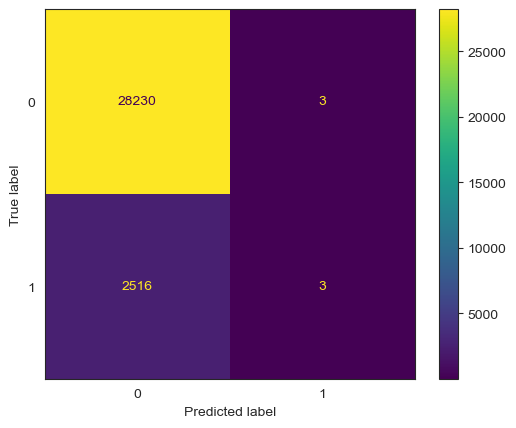

In [118]:
disp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_hat_lr))
disp.plot()
plt.show()

In [120]:
print(classification_report(y_test, y_hat_lr))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28233
           1       0.50      0.00      0.00      2519

    accuracy                           0.92     30752
   macro avg       0.71      0.50      0.48     30752
weighted avg       0.88      0.92      0.88     30752



In [119]:
f1_scores_lr = []
accuracies_lr = []
precisions_lr = []
recall_lr = []
pred_proba_df = pd.DataFrame(model_lr.predict_proba(X2_test_sc))
threshold_list = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.15, 0.2,
                  0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for i in threshold_list:
#     print ('\n******** For Treshold = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
#     test_accuracy = metrics.accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
#                                            Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1))
    recall = recall_score(y_test, Y_test_pred[1].values,zero_division=0)
    precision = precision_score(y_test, Y_test_pred[1].values,zero_division=0)
    accuracy = accuracy_score(y_test, Y_test_pred[1].values)
    f1 = round((2 * precision * recall)/(precision + recall), 5)
    f1_scores_lr.append(f1)
    accuracies_lr.append(accuracy)
    recall_lr.append(recall)
    precisions_lr.append(precision)
#     print('Accuracy: {}, Precision: {}, recall: {}, : F1: {}'.format(accuracy, recall, precision, f1))

#     print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
#                            Y_test_pred.iloc[:,1].as_matrix().reshape(Y_test_pred.iloc[:,1].as_matrix().size,1)))

In [120]:
df_lr = pd.DataFrame(data={"Accuracy_lr": accuracies_lr,"Recall_lr": recall_lr,
                        "Precision_lr": precisions_lr,"F1_lr": f1_scores_lr})

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Assuming 'X_train' and 'y_train' are your training data and labels

# Define the Decision Tree model
model = DecisionTreeClassifier()

# Reduce the size of the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],  # Adjusted values
    'min_samples_split': [2, 5],  # Adjusted values
    'min_samples_leaf': [1, 2],   # Adjusted values
    'max_features': [None, 'sqrt', 'log2']
}

# Create GridSearchCV with 2-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)



Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best Accuracy: 0.9190595430522073


In [122]:
from sklearn.metrics import classification_report

# ... (previous code)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28233
           1       0.30      0.00      0.00      2519

    accuracy                           0.92     30752
   macro avg       0.61      0.50      0.48     30752
weighted avg       0.87      0.92      0.88     30752



Confusion Matrix:
[[28226     7]
 [ 2516     3]]


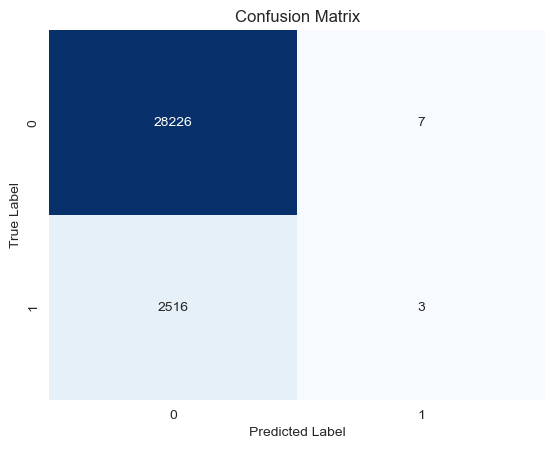

In [125]:
# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Assuming 'X_train' and 'y_train' are your training data and labels

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define the parameter distribution to sample from
param_dist = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

# Create RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(estimator=knn_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)


Best Parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'algorithm': 'kd_tree'}
Best Accuracy: 0.9185862067938168


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28233
           1       0.23      0.00      0.01      2519

    accuracy                           0.92     30752
   macro avg       0.58      0.50      0.48     30752
weighted avg       0.86      0.92      0.88     30752

Confusion Matrix:
[[28200    33]
 [ 2509    10]]


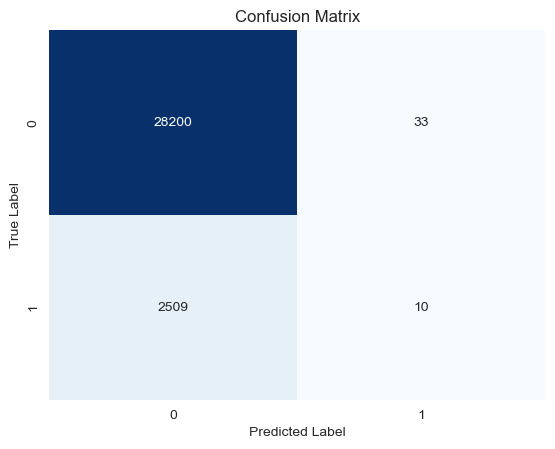

In [126]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()




* High precision in LogisticRegression is misleading: algorithm predicts very small number of defaulters (recall is very small) so this metric is not much reliable in this case

### Resample

As the dataset is highly imbalanced (only 7% of observations belong to class 1), trying oversampling (using **SMOTE** or other technique) should be good idea

In [123]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=444).fit_resample(X2_train_sc, y2_train)
print(sorted(Counter(y_resampled).items()))

[(0, 254453), (1, 254453)]


In [124]:
X_resampled.shape, y_resampled.shape

((508906, 158), (508906,))

#### Logistic Regression

In [125]:
%%time
model_lr = LogisticRegression(random_state=444, solver="saga", max_iter=200)

model_params = {
   'C': [100, 10, 1.0, 0.1, 0.01]
 }

model_lr = GridSearchCV(model_lr, model_params, cv=3, verbose=True,
                         scoring='balanced_accuracy')

model_lr = model_lr.fit(X_resampled, y_resampled)
print(model_lr.best_params_)
print(model_lr.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 0.1}
0.6729985617052098
CPU times: user 20min 2s, sys: 22.3 s, total: 20min 24s
Wall time: 20min 10s


In [126]:
model_lr = LogisticRegression(random_state=444, solver="saga",
                              max_iter=200, C=100)
model_lr.fit(X_resampled, y_resampled)
y_hat_lr = model_lr.predict(X2_test_sc)

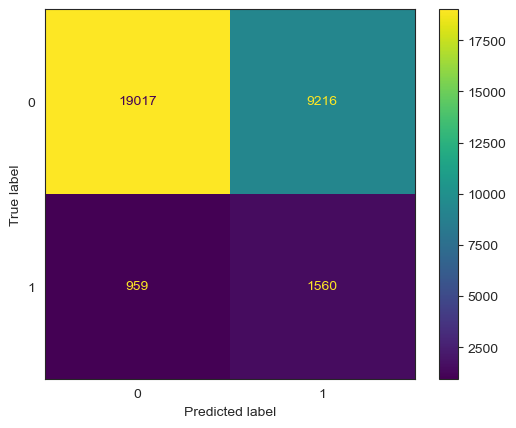

In [127]:
disp = ConfusionMatrixDisplay(confusion_matrix(y2_test, y_hat_lr))
disp.plot()
plt.show()

In [128]:
print(classification_report(y2_test, y_hat_lr))

              precision    recall  f1-score   support

           0       0.95      0.67      0.79     28233
           1       0.14      0.62      0.23      2519

    accuracy                           0.67     30752
   macro avg       0.55      0.65      0.51     30752
weighted avg       0.89      0.67      0.74     30752



### Results 

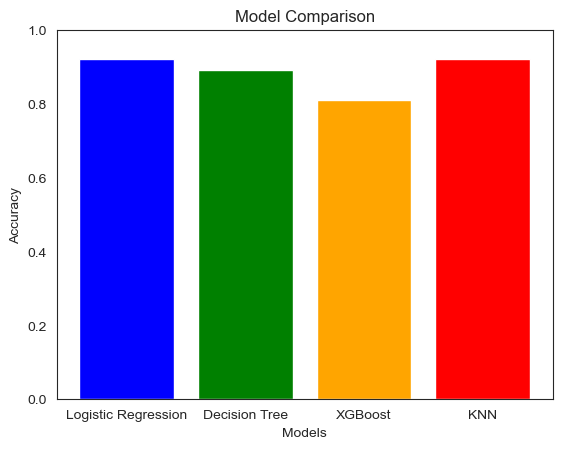

In [132]:
import matplotlib.pyplot as plt

# Assuming you have variables accuracy_lr, test_accuracy, accuracy, and knn_accuracy

models = ['Logistic Regression', 'Decision Tree', 'XGBoost', 'KNN']
accuracies = [accuracy_lr, test_accuracy, accuracy, accuracy_knn]

plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)  # Adjust the y-axis limit based on your accuracy values
plt.show()


**We can choose strategies depending on treshold we choose**

#####  Best Strategy 

We can choose **KNN Model** after comparison with all other models which becomes our best choice:
* **Accuracy: 92%** (Model predicts costumers status with 92% accuracy)
* **F-1 Score: 96%** (Model can classify Positive or Negative )


##### **Conclusion**

* **KNN Model identifies most of the Defaulters but with a cost of non-default costumers: only 10% of predicted Defaulters will be actually defaulter**
* **Model identifies only 10% of Defaulters but on the other hand it won't lose as much non-default costumers as in Case I if we go with Logistic Regression**.